# 3. Fitting diads once you have groups
- Once you have divided your diads into groups based on strengths, you need to tweak the fit parameters for each group
- Then you can loop through all files in a given group and automatically fit the spectra

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'0.0.77'

## Specifying filetype, and folder as before

In [51]:
# This specifies what file type your Raman exported in. 
meta_path, spectra_path, filetype, prefix, prefix_str, file_ext, TruPower=pf.get_settings()

## Load in data and fit parameters
- This loads in the dataframes of the fit parameters you saved in the other file, by group
- At this point you select what group you want to fit (batch = 'Weak', 'Medium' or 'Strong'). After running through the entire notebook for one group, come back up here to fit a second group.

In [52]:
## load dataframes and numpy arrays 
np_x = joblib.load('np_x.sav')

# Select the group you want to fit ('Weak', 'Medium', 'Strong'). After selecting one, go through and select another one and run again from here. 
batch='Medium' # Options are Weak, Medium, Strong

if batch=='Weak':
    GroupN_df=joblib.load('Weak_df.sav')
if batch=='Medium':
    GroupN_df=joblib.load('Medium_df.sav')
if batch=='Strong':
    GroupN_df=joblib.load('Strong_df.sav')

### Now load one file from this group to tweak parameters for

In [53]:
Diad_Files =GroupN_df['filename']
i=0


### Lets plot the diad to have a look at it

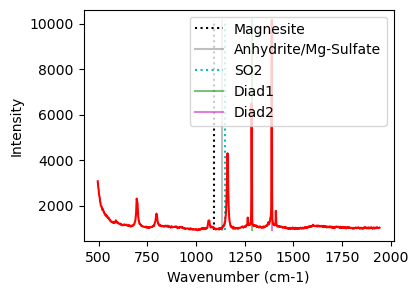

In [54]:
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=filetype)

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

## Choose a model for fitting all peaks
- Option of Voigt or PseudoVoigt. We recomend PsuedoVoigt

In [55]:
model_name='PseudoVoigtModel'

## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [56]:
diad_id_config=pf.diad_id_config(height=50, exclude_range1=[1308, 1309])
diad_id_config

if batch=='Weak':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=1,
    N_poly_bck_diad1=2, lower_bck_diad1=(1250, 1275),
    upper_bck_diad1=(1300, 1350),
    diad_sigma=1.1,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init


if batch=='Medium':
    diad1_fit_config_init=pf.diad1_fit_config(
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=100, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
    diad1_fit_config_init

if batch=='Strong':
    diad1_fit_config_init=pf.diad1_fit_config(
    fit_gauss=True, gauss_amp= 2*GroupN_df['HB1_abs_prom'].iloc[i],
    model_name=model_name, fit_peaks=2,
    N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220),
    upper_bck_diad1=(1330, 1350),
    diad_sigma=0.6,
    x_range_residual=10, x_range_baseline=30, 
     y_range_baseline=1000, 
    HB_prom=GroupN_df['HB1_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=1, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=5486.6404798749, HB_prom=463.8575387194586, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

Diad1_Combofit_Cent  Diad1_Voigt_Cent  Diad1_cent_err  Diad1_Voigt_Area  \
0          1285.527123       1285.527273        0.011785      16313.787114   

   Diad1_Voigt_Sigma  Diad1_Voigt_Gamma     HB1_Cent     HB1_Area  HB1_Sigma  \
0           1.108289                  0  1265.419627  3360.928851   3.308807   

   Diad1_Combofit_Height  Diad1_Residual  Diad1_Prop_Lor  Diad1_fwhm  \
0            5619.914244       34.965595        0.584543    2.216578   

         Diad1_refit  
0  Flagged Warnings:

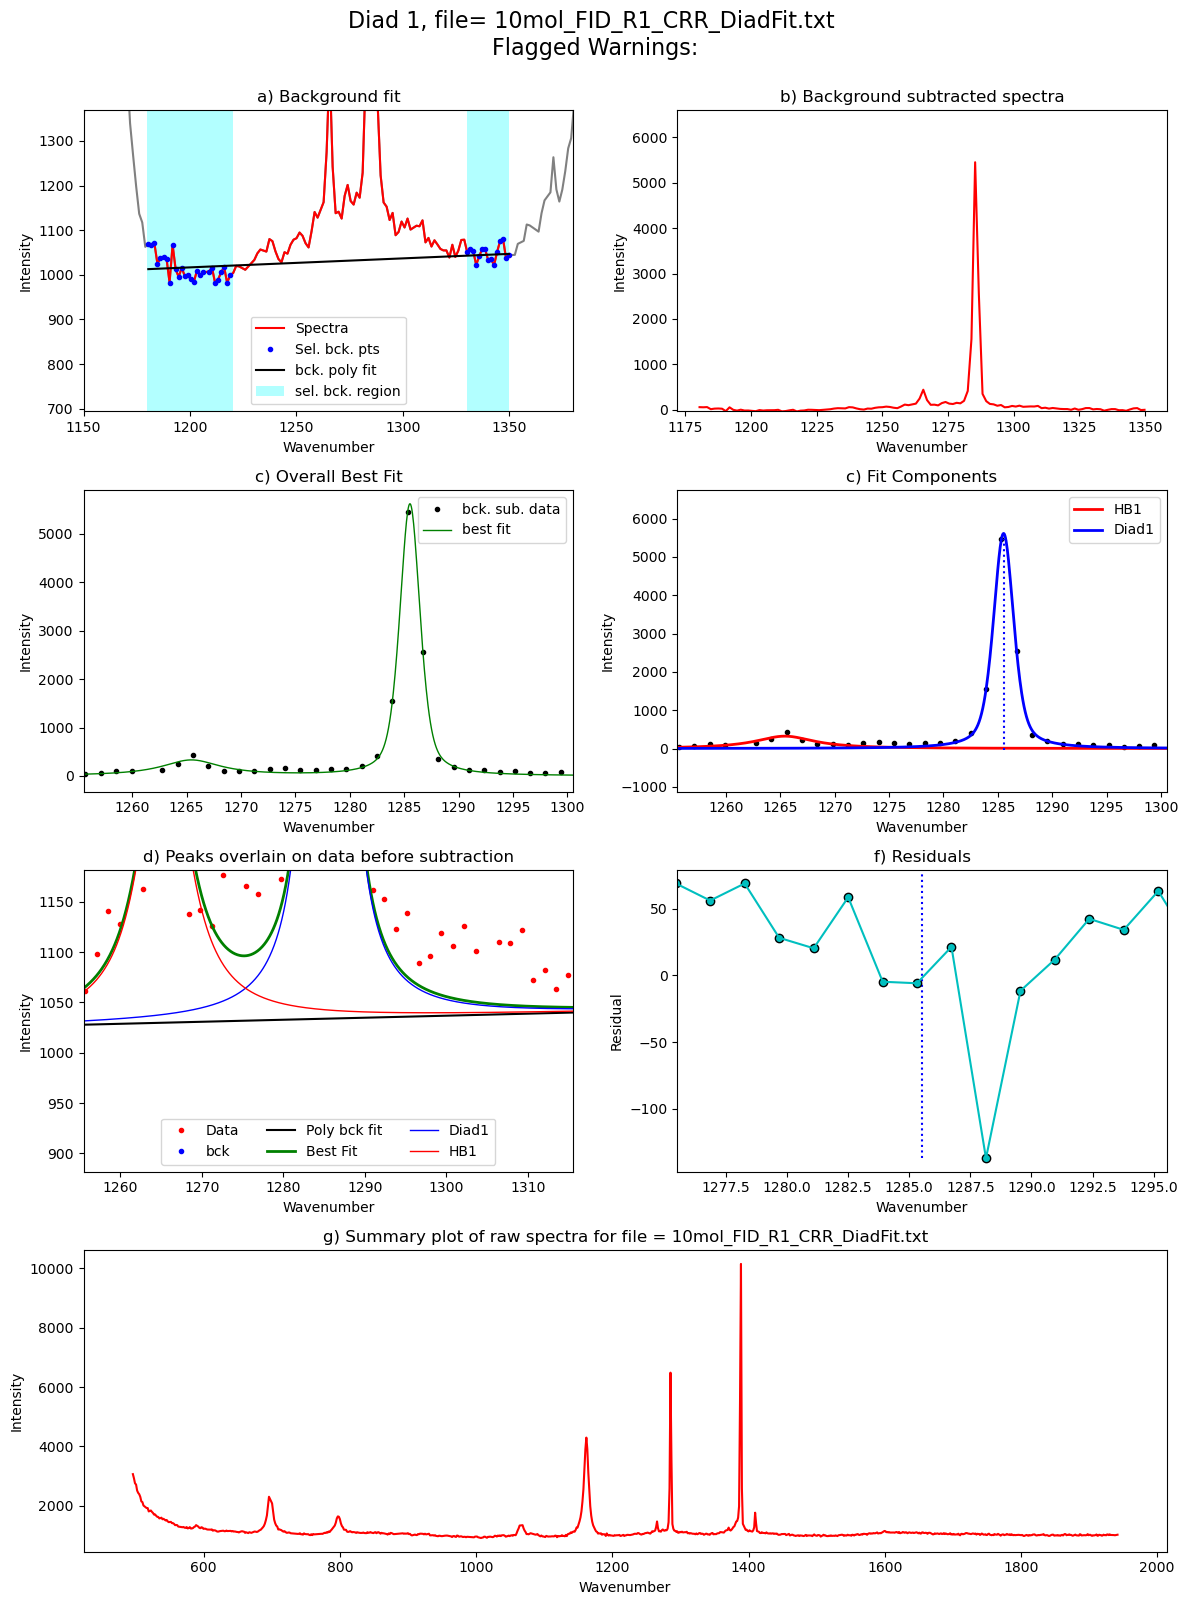

In [57]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=Diad_Files.iloc[0],
filetype=filetype, plot_figure=True, close_figure=False,
Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
HB_pos=GroupN_df['HB1_pos'].iloc[i])
Diad1_fit

### Update the sigma
- The sigma parameter varies quite a lot based on the splitting. Best to update your first guess with what you found for the example file above

In [58]:
diad1_fit_config2=diad1_fit_config_init

## Fit diad2

In [59]:
if batch=='Weak':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=1, upper_bck_diad2=(1394, 1399),
    lower_bck_diad2=(1370, 1384), diad_sigma=1,  N_poly_bck_diad2=1,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Medium':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=2,
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=1,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init

if batch=='Strong':
    diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    fit_peaks=3, fit_gauss=True, gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i],
    lower_bck_diad2=(1310, 1340), diad_sigma=1,  N_poly_bck_diad2=2,                                       
    x_range_residual=30, y_range_baseline=1000,  
    x_range_baseline=30,
    HB_prom=GroupN_df['HB2_abs_prom'].iloc[i], 
    diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i],
    C13_prom=GroupN_df['C13_abs_prom'].iloc[i])
    diad2_fit_config_init
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad2=1, lower_bck_diad2=(1310, 1340), upper_bck_diad2=(1440, 1470), fit_gauss=False, gauss_amp=1000, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=9224.272171674049, HB_prom=746.9267532430453, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False, C13_prom=99.33880539027678)

### See what these fit parameters look like for diad2

Diad2_Combofit_Cent  Diad2_Voigt_Cent  Diad2_cent_err  Diad2_Voigt_Area  \
0          1388.365087       1388.365037        0.048179      27687.723804   

   Diad2_Voigt_Sigma  Diad2_Voigt_Gamma     HB2_Cent     HB2_Area  HB2_Sigma  \
0           0.700351                  0  1409.825158  2758.629639   1.205366   

   Diad2_Combofit_Height  Diad2_Residual  Diad2_Prop_Lor  Diad2_fwhm  \
0           12748.395145       63.310647        0.972933    1.400702   

         Diad2_refit  
0  Flagged Warnings:

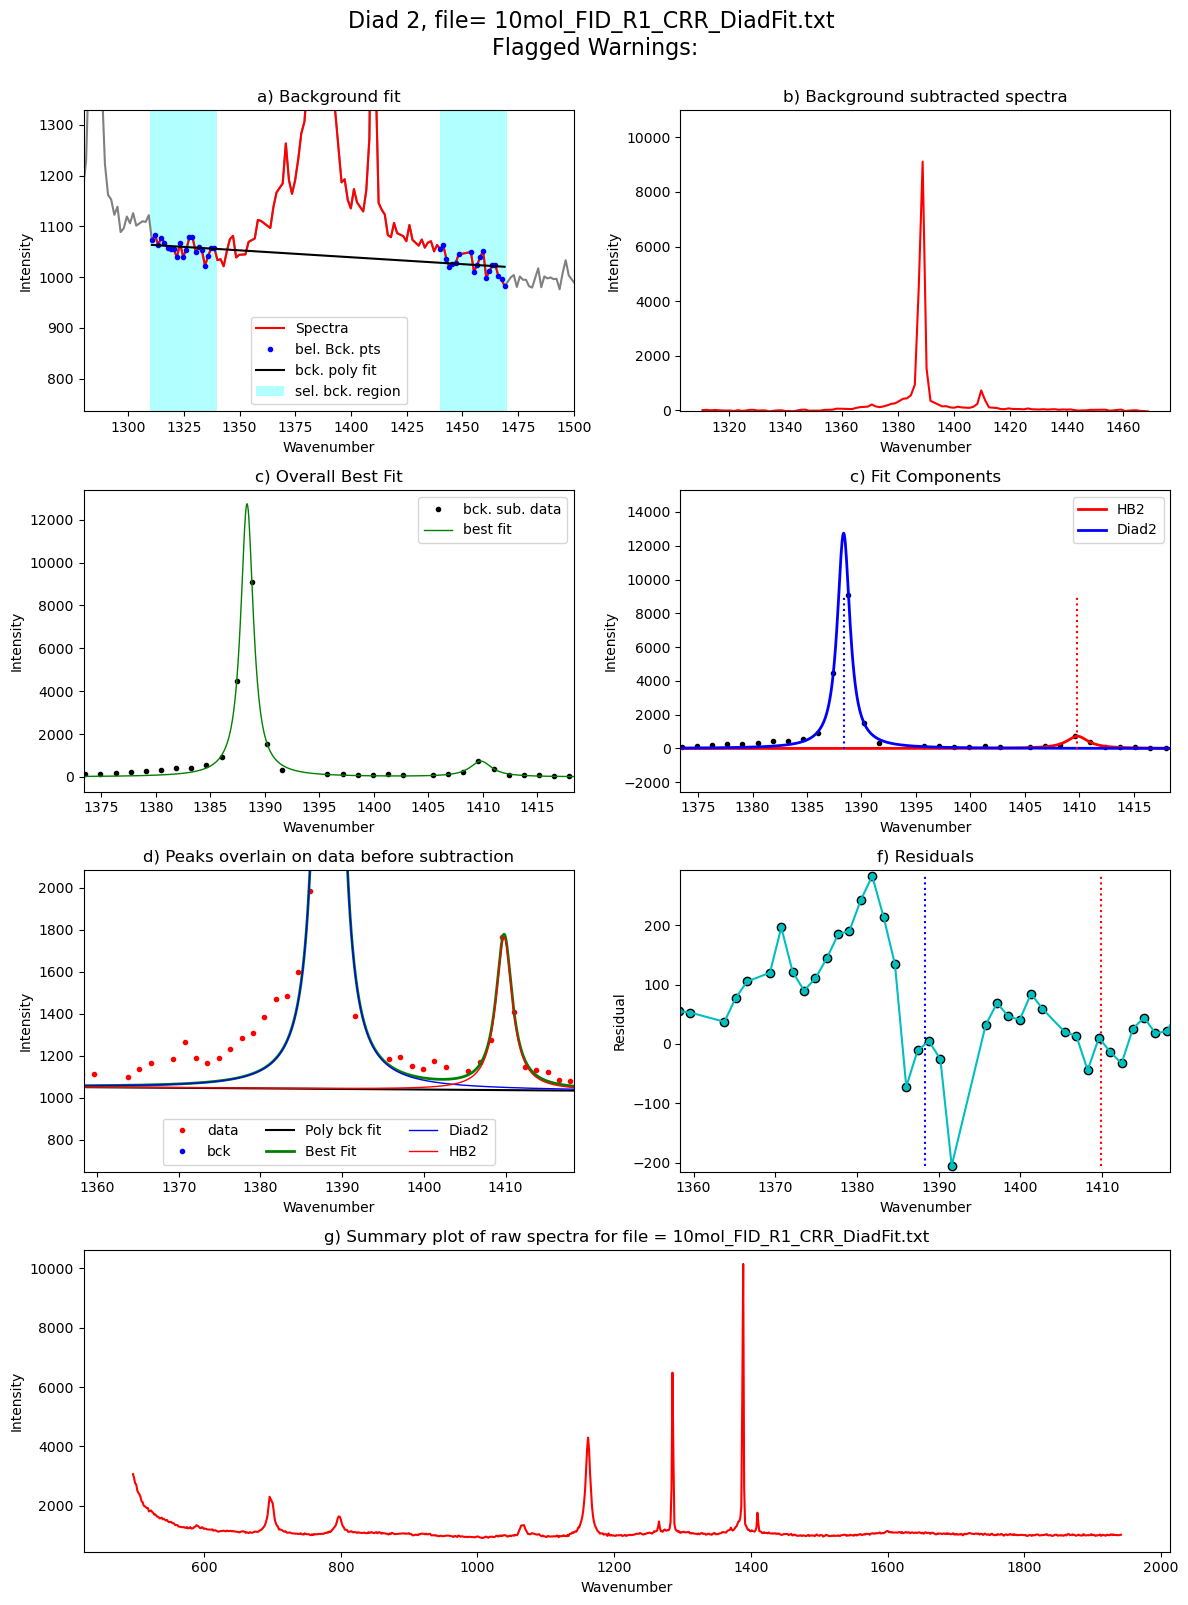

In [60]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i], filetype=filetype,
plot_figure=True, close_figure=False, 
Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
HB_pos=GroupN_df['HB2_pos'].iloc[i], 
C13_pos=GroupN_df['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

## Loop over all the files in the group
- This will loop over all the 

  0%|          | 0/13 [00:00<?, ?it/s]

Processing file: 10mol_FID_R1_CRR_DiadFit.txt


  8%|▊         | 1/13 [00:02<00:35,  2.94s/it]

Processing file: 10mol_FID_R1_FIN_CRR_DiadFit.txt


 15%|█▌        | 2/13 [00:05<00:27,  2.51s/it]

Processing file: 10mol_FID_R2_CRR_DiadFit.txt


 23%|██▎       | 3/13 [00:07<00:24,  2.50s/it]

Processing file: 10mol_FID_R2_FIN_CRR_DiadFit.txt


 31%|███       | 4/13 [00:09<00:21,  2.34s/it]

Processing file: 10mol_FID_R3_CRR_DiadFit.txt


 38%|███▊      | 5/13 [00:11<00:17,  2.25s/it]

Processing file: 10mol_FID_R3_FIN_CRR_DiadFit.txt


 46%|████▌     | 6/13 [00:13<00:14,  2.10s/it]

Processing file: 10mol_FIE_R1_CRR_DiadFit.txt


 54%|█████▍    | 7/13 [00:16<00:13,  2.31s/it]

Processing file: 10mol_FIE_R1_FIN_CRR_DiadFit.txt


 62%|██████▏   | 8/13 [00:18<00:10,  2.13s/it]

Processing file: 10mol_FIE_R2_CRR_DiadFit.txt


 69%|██████▉   | 9/13 [00:20<00:08,  2.15s/it]

Processing file: 10mol_FIE_R2_FIN_CRR_DiadFit.txt


 77%|███████▋  | 10/13 [00:22<00:06,  2.02s/it]c:\users\penny\onedrive\documents\berkeley_new\diadfit_outer\src\DiadFit\diads.py:2976: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(12, 16))


Processing file: 10mol_FIE_R3_CRR_DiadFit.txt


 85%|████████▍ | 11/13 [00:23<00:03,  1.94s/it]

Processing file: 10mol_FIE_R3_FIN_CRR_DiadFit.txt


 92%|█████████▏| 12/13 [00:26<00:02,  2.16s/it]

Processing file: 1mol_FIB_R1_CRR_DiadFit.txt


100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


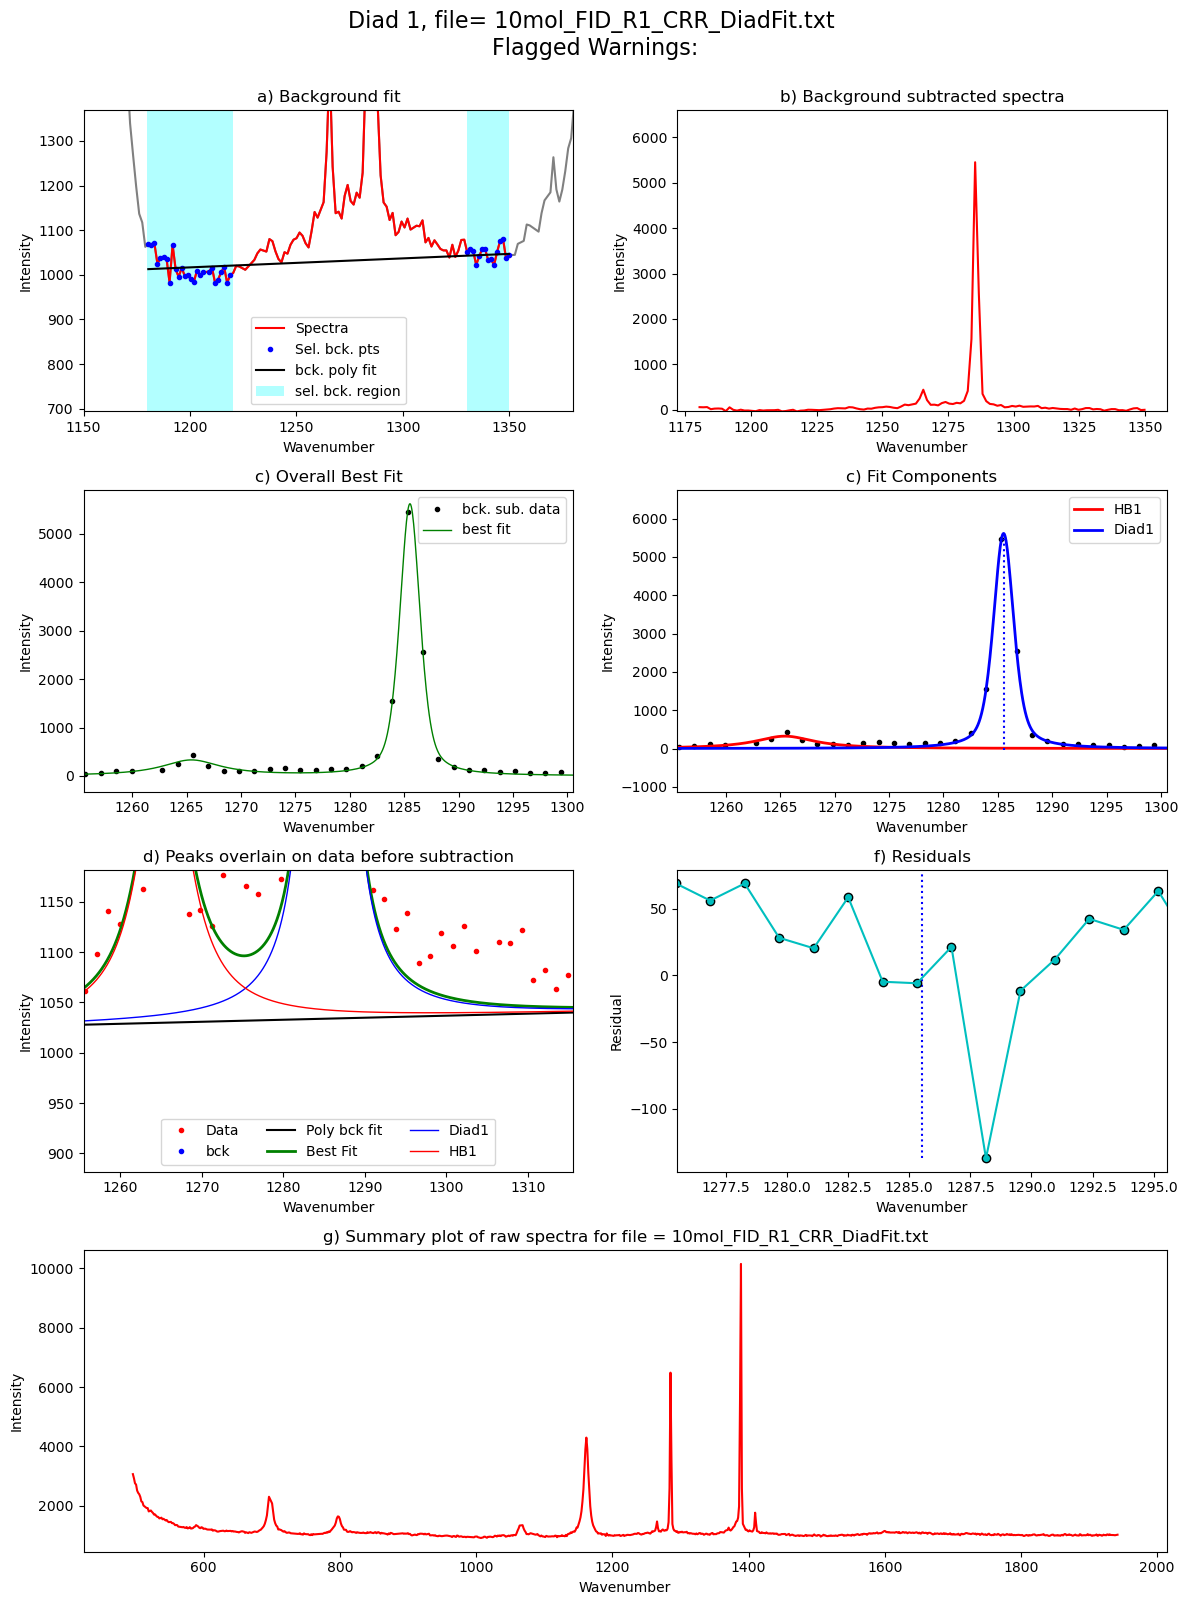

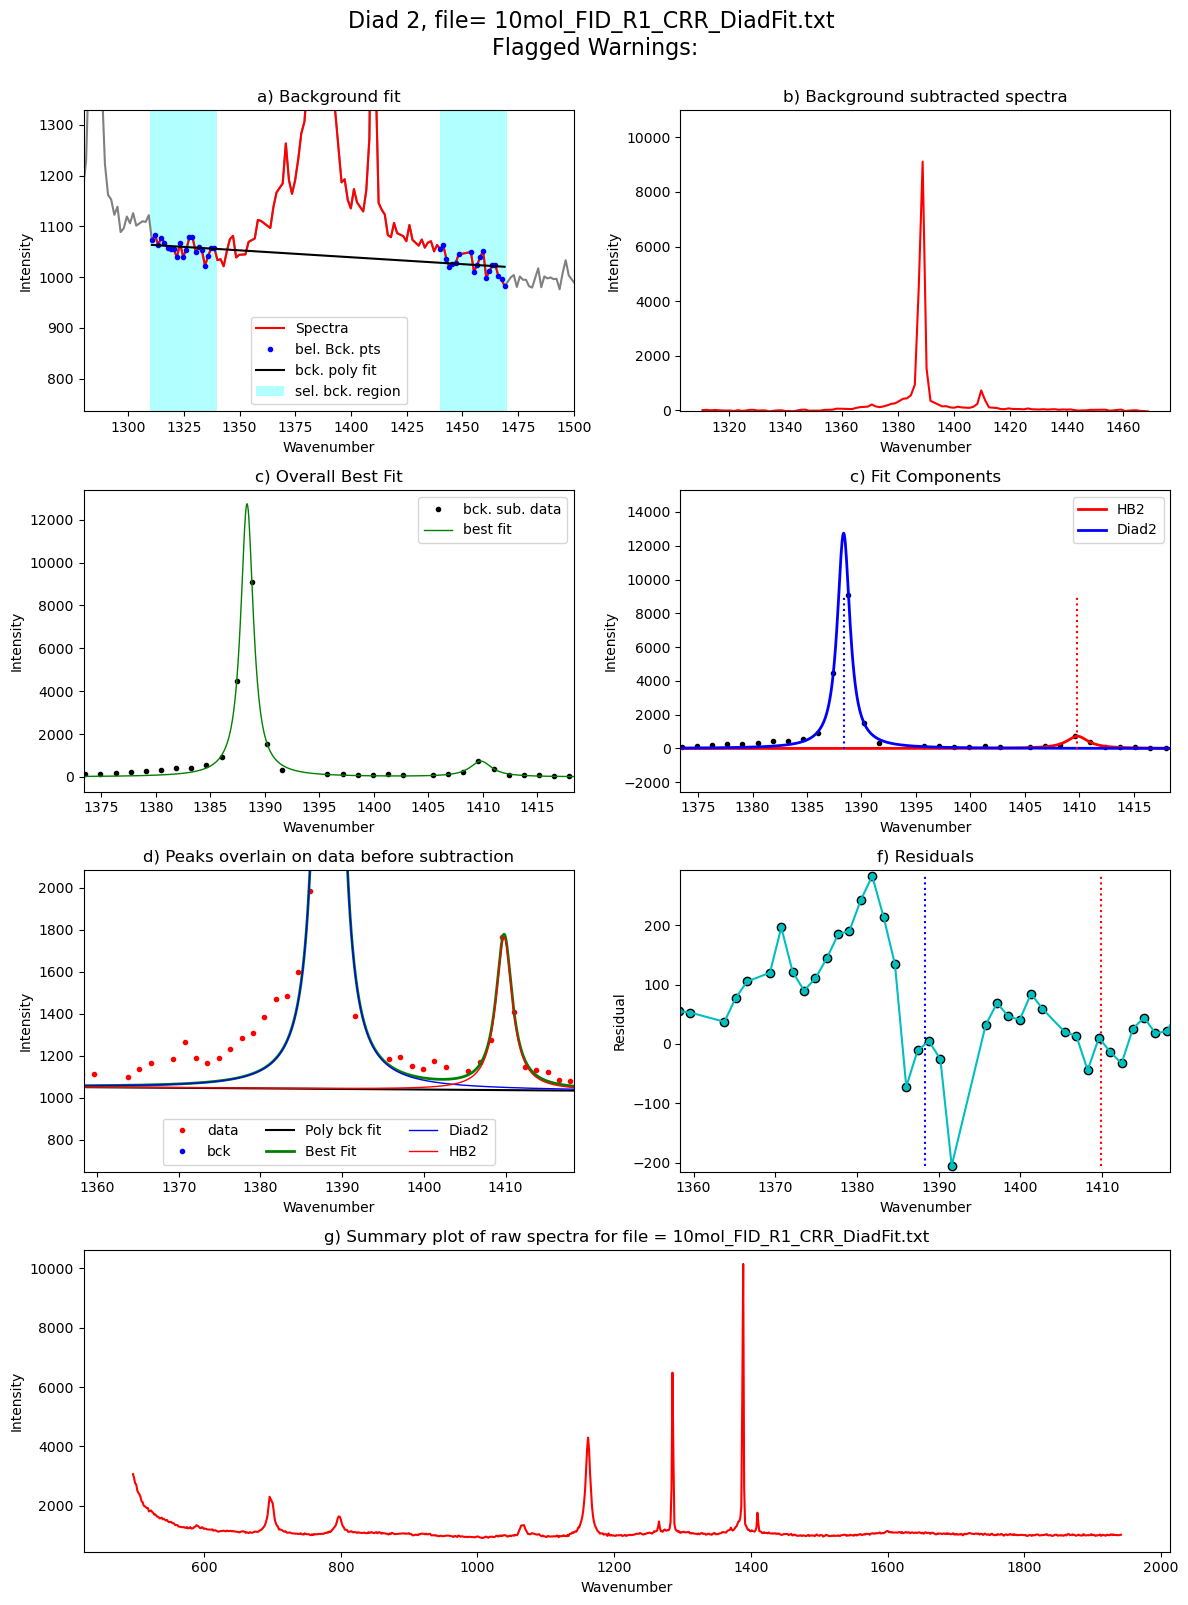

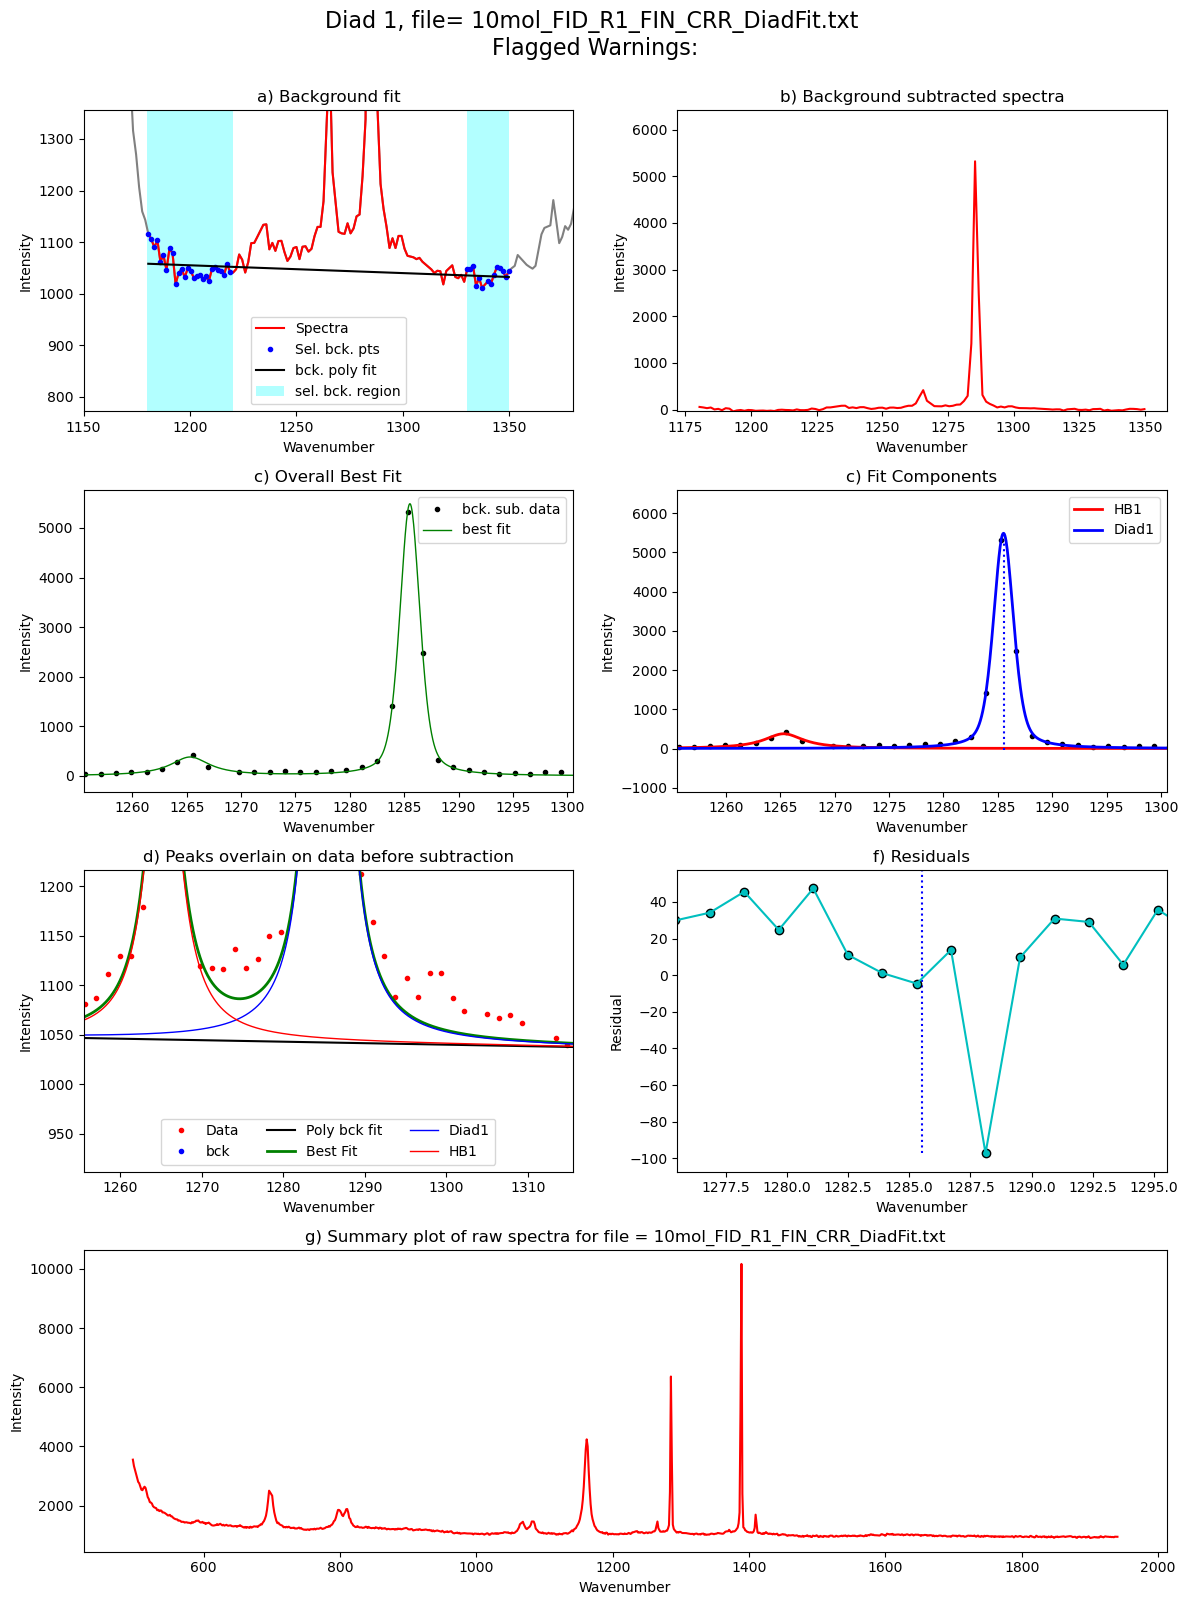

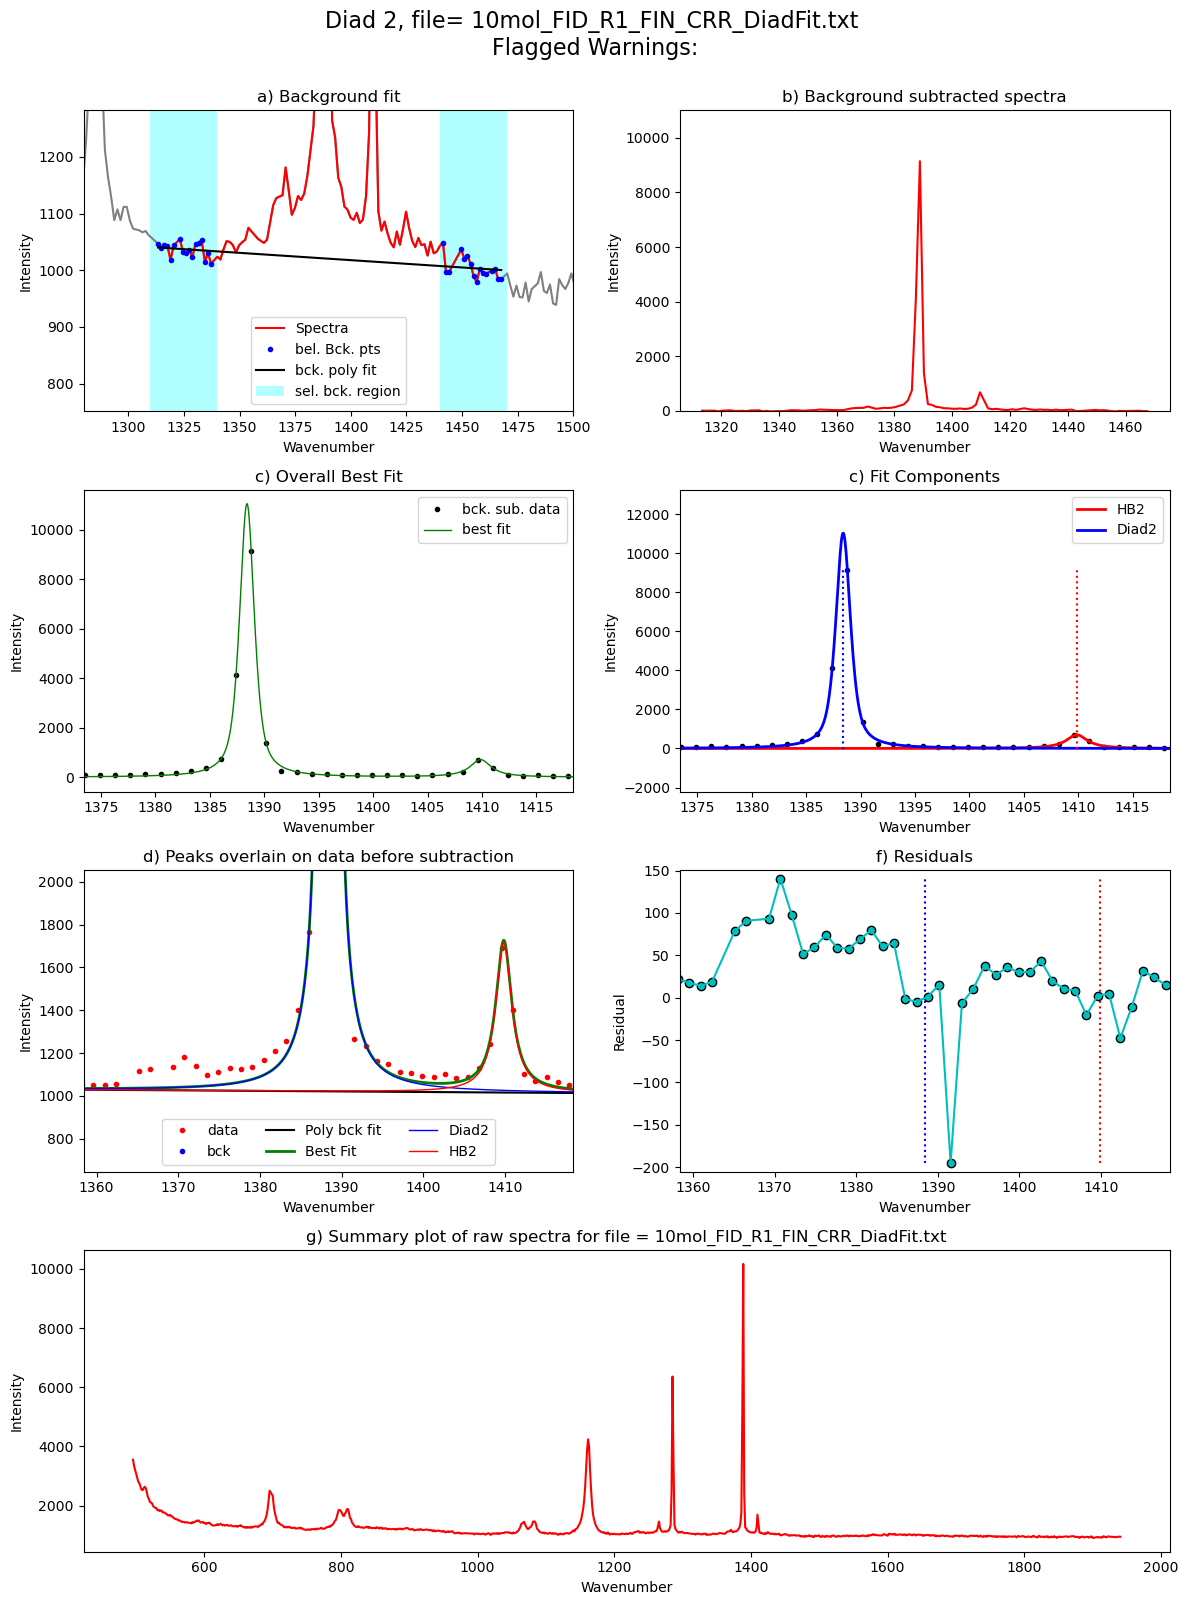

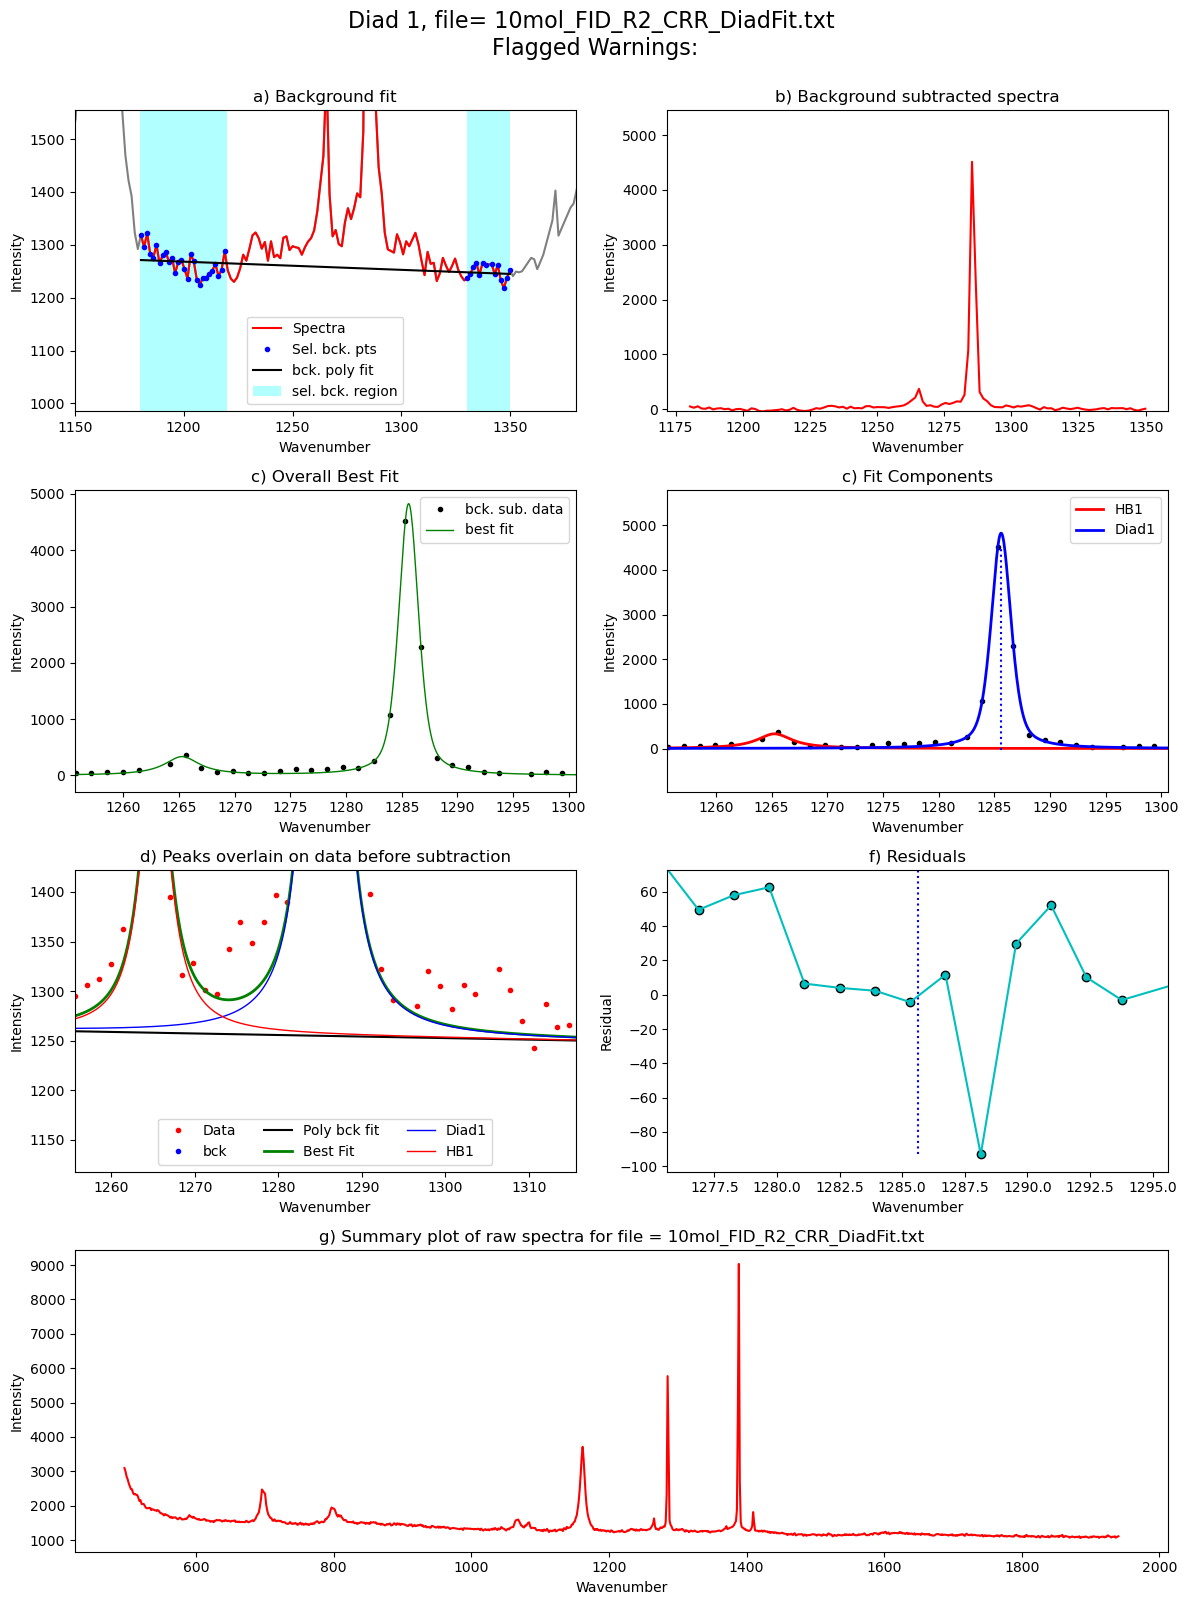

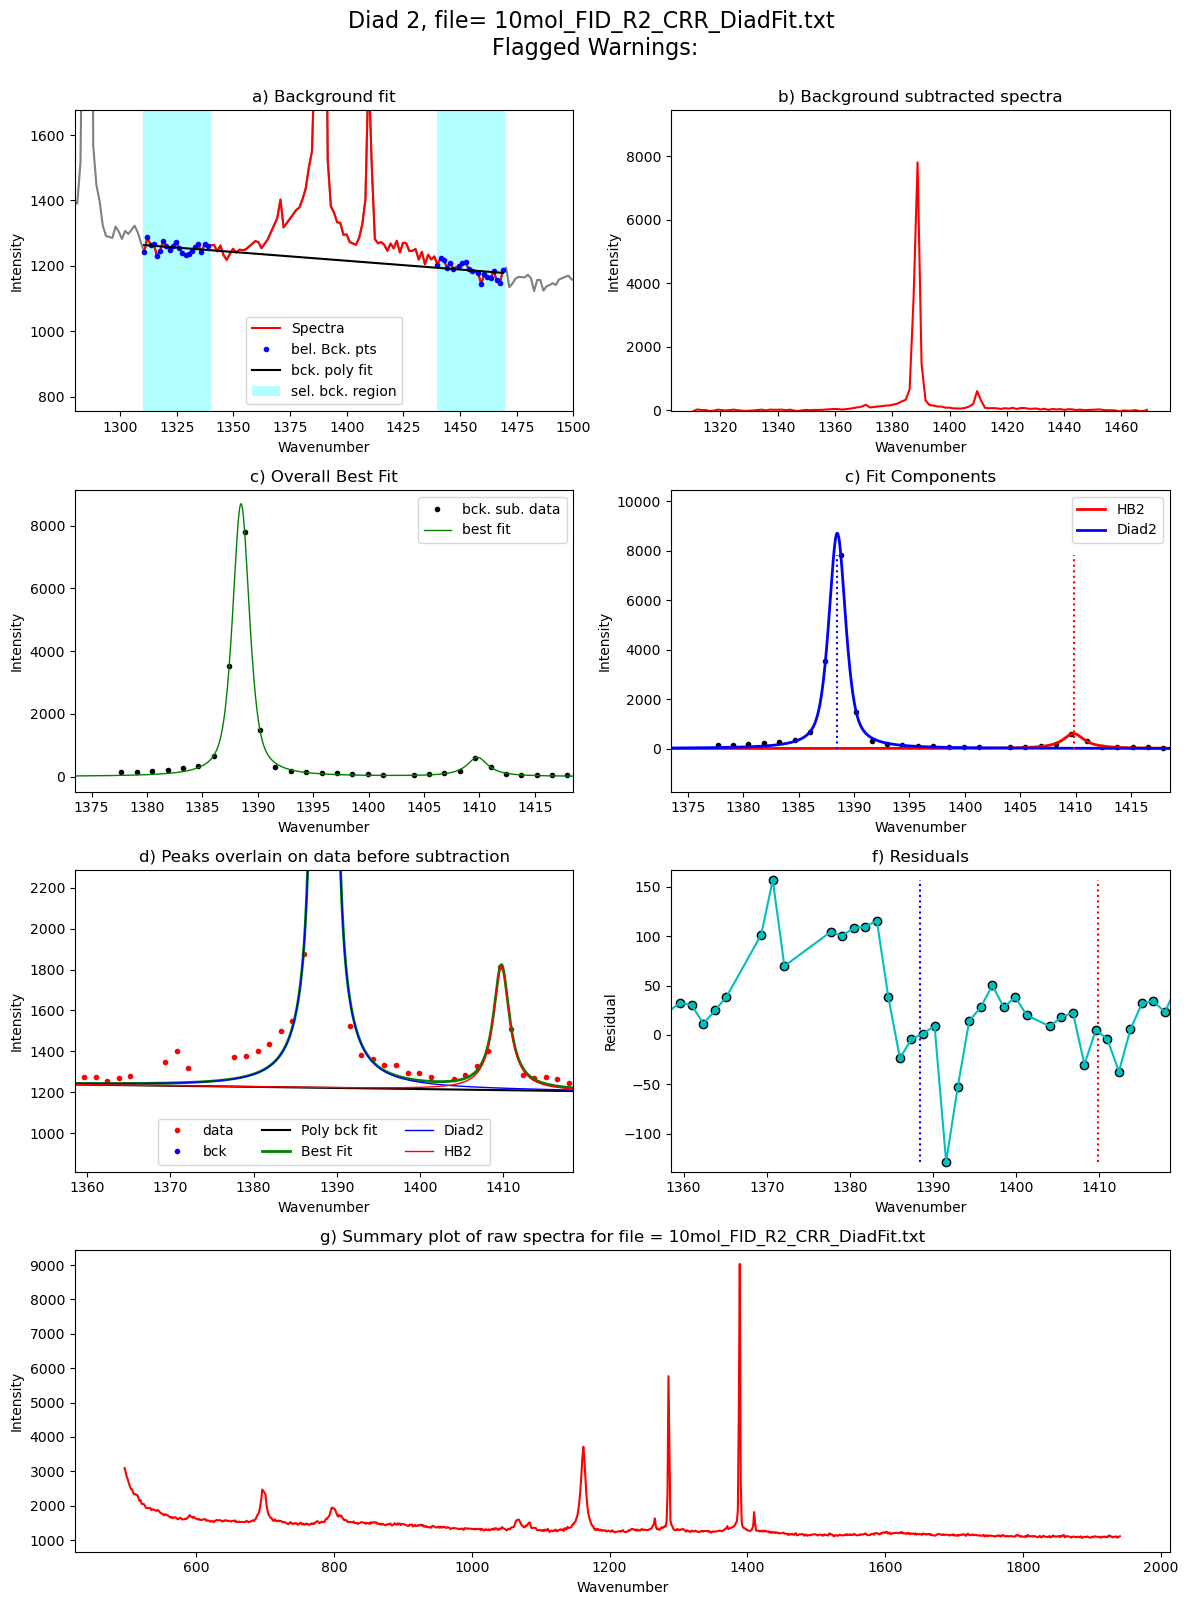

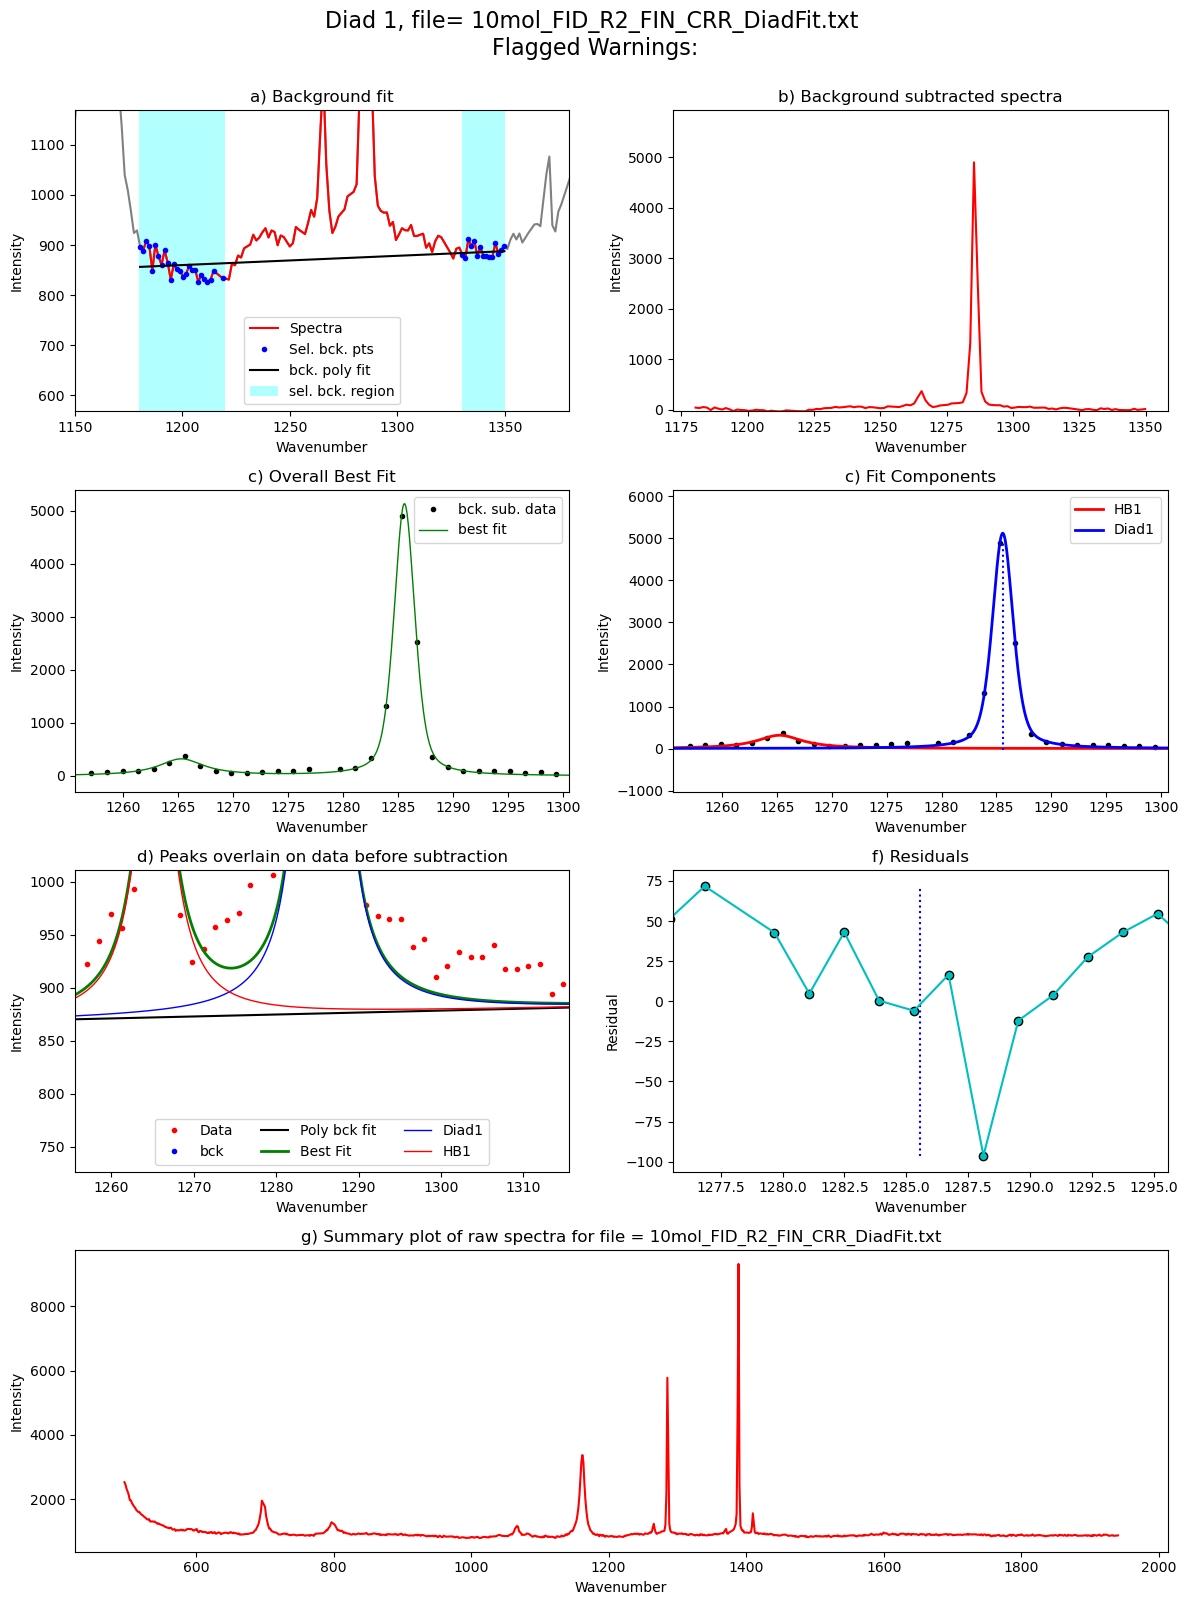

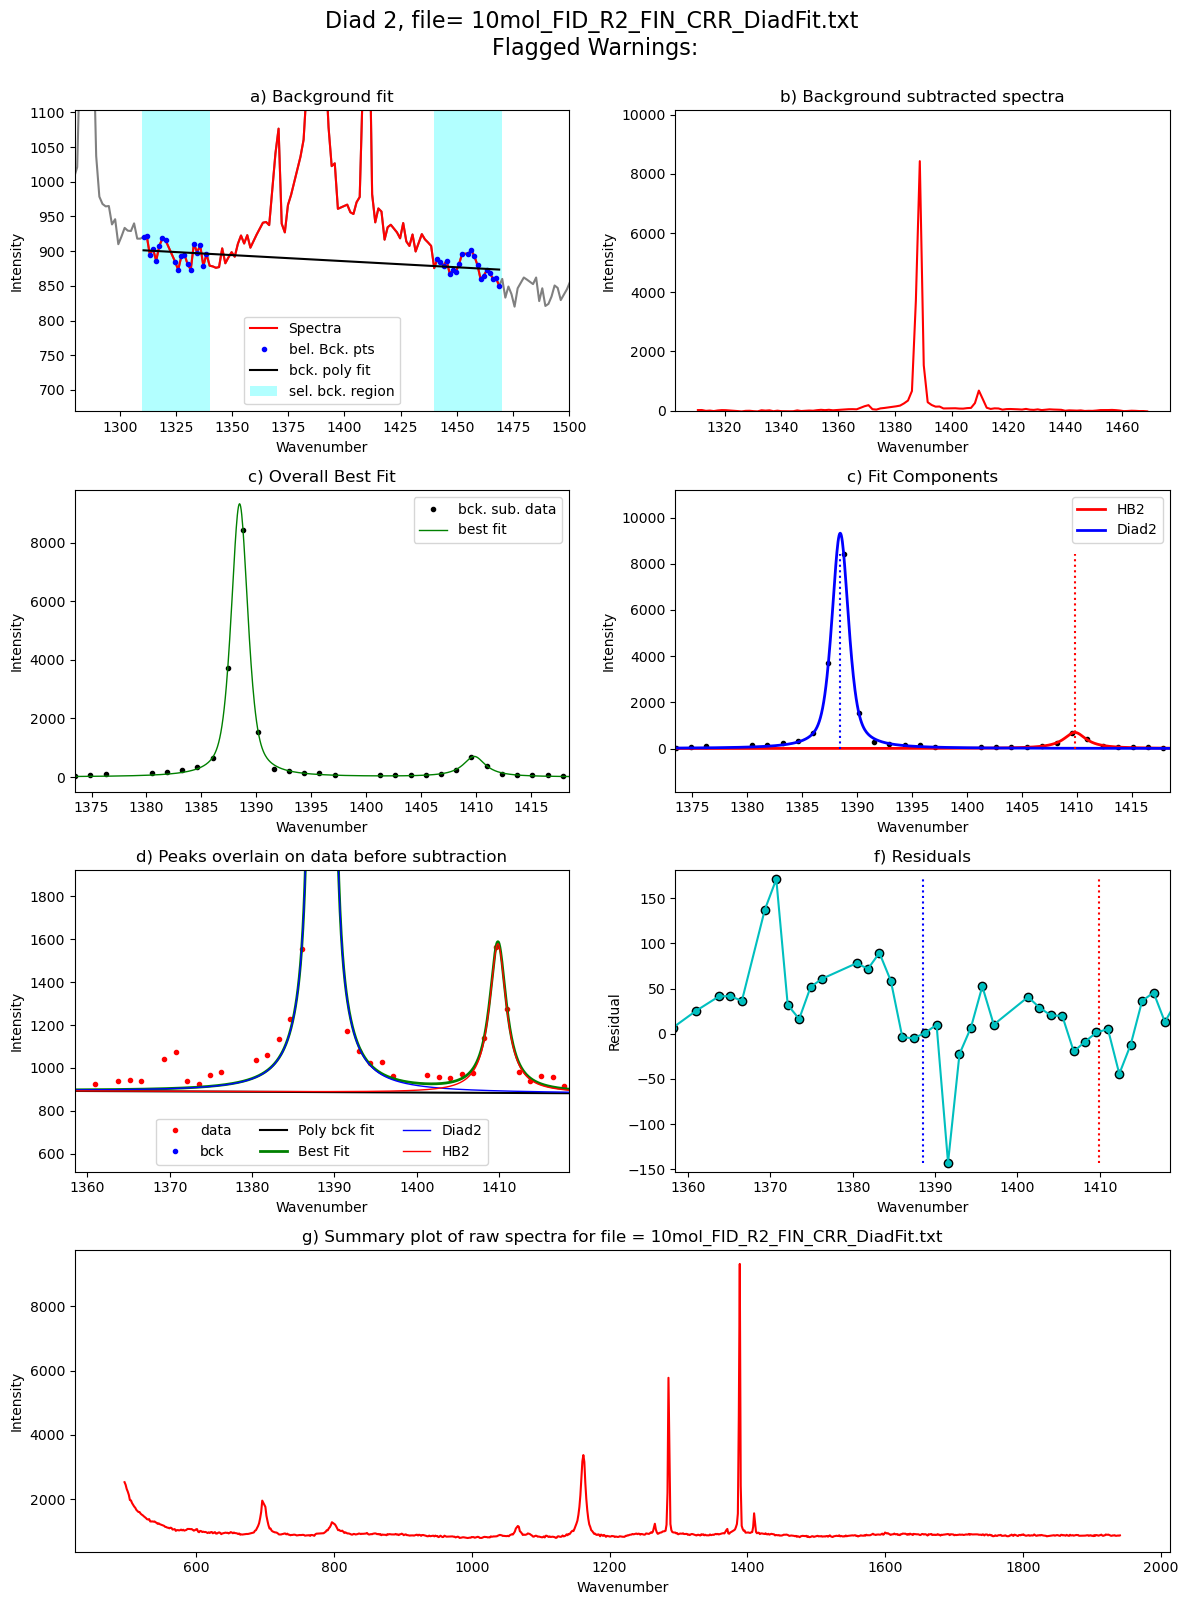

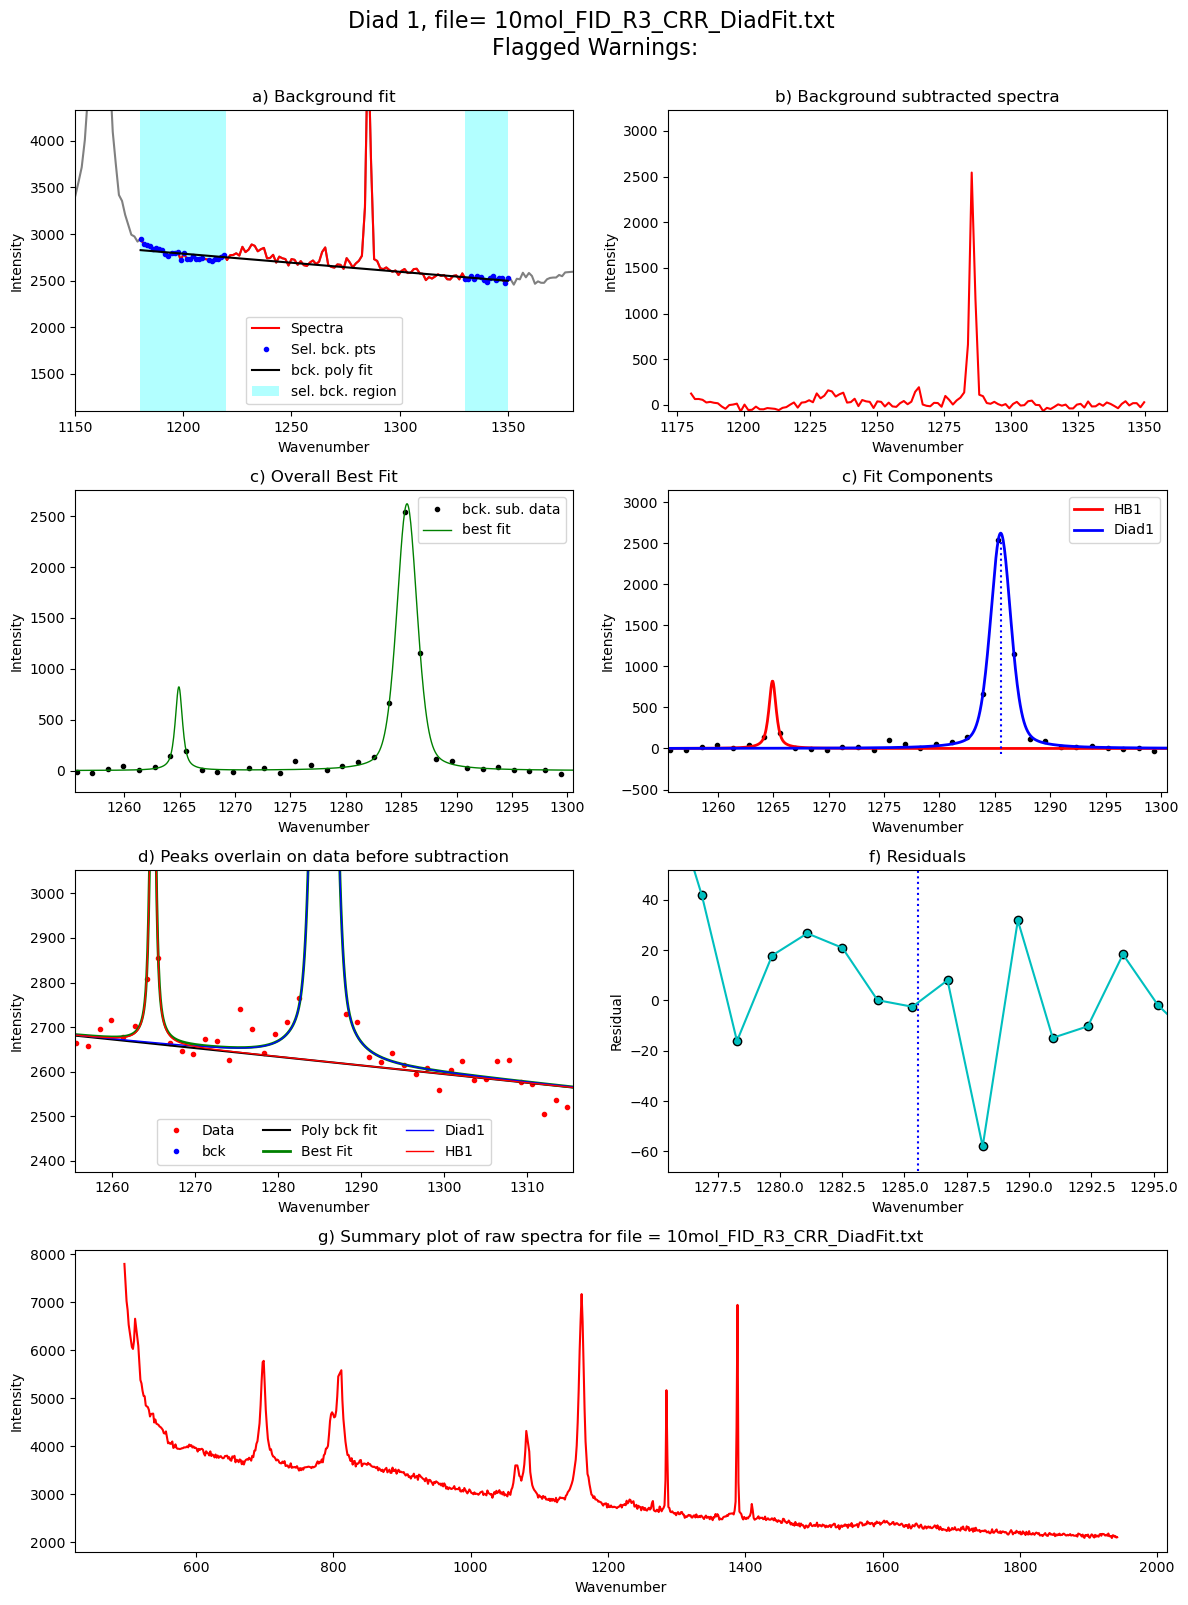

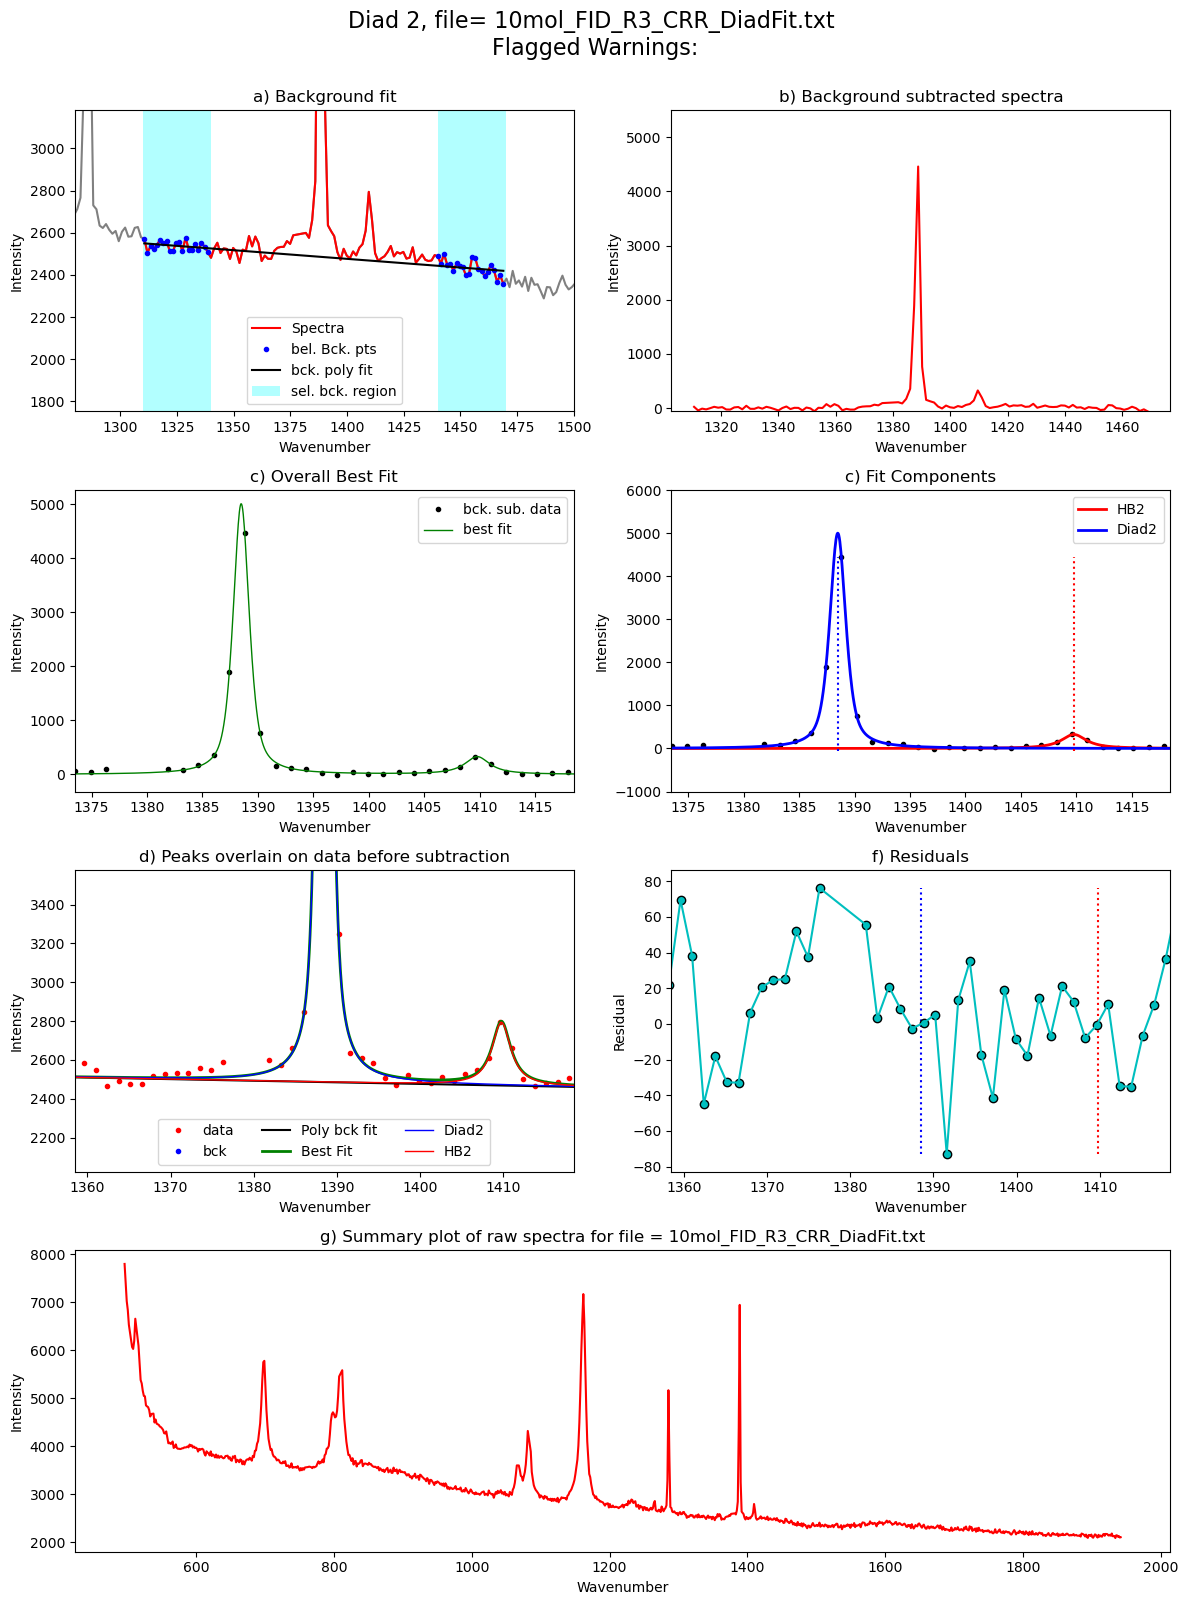

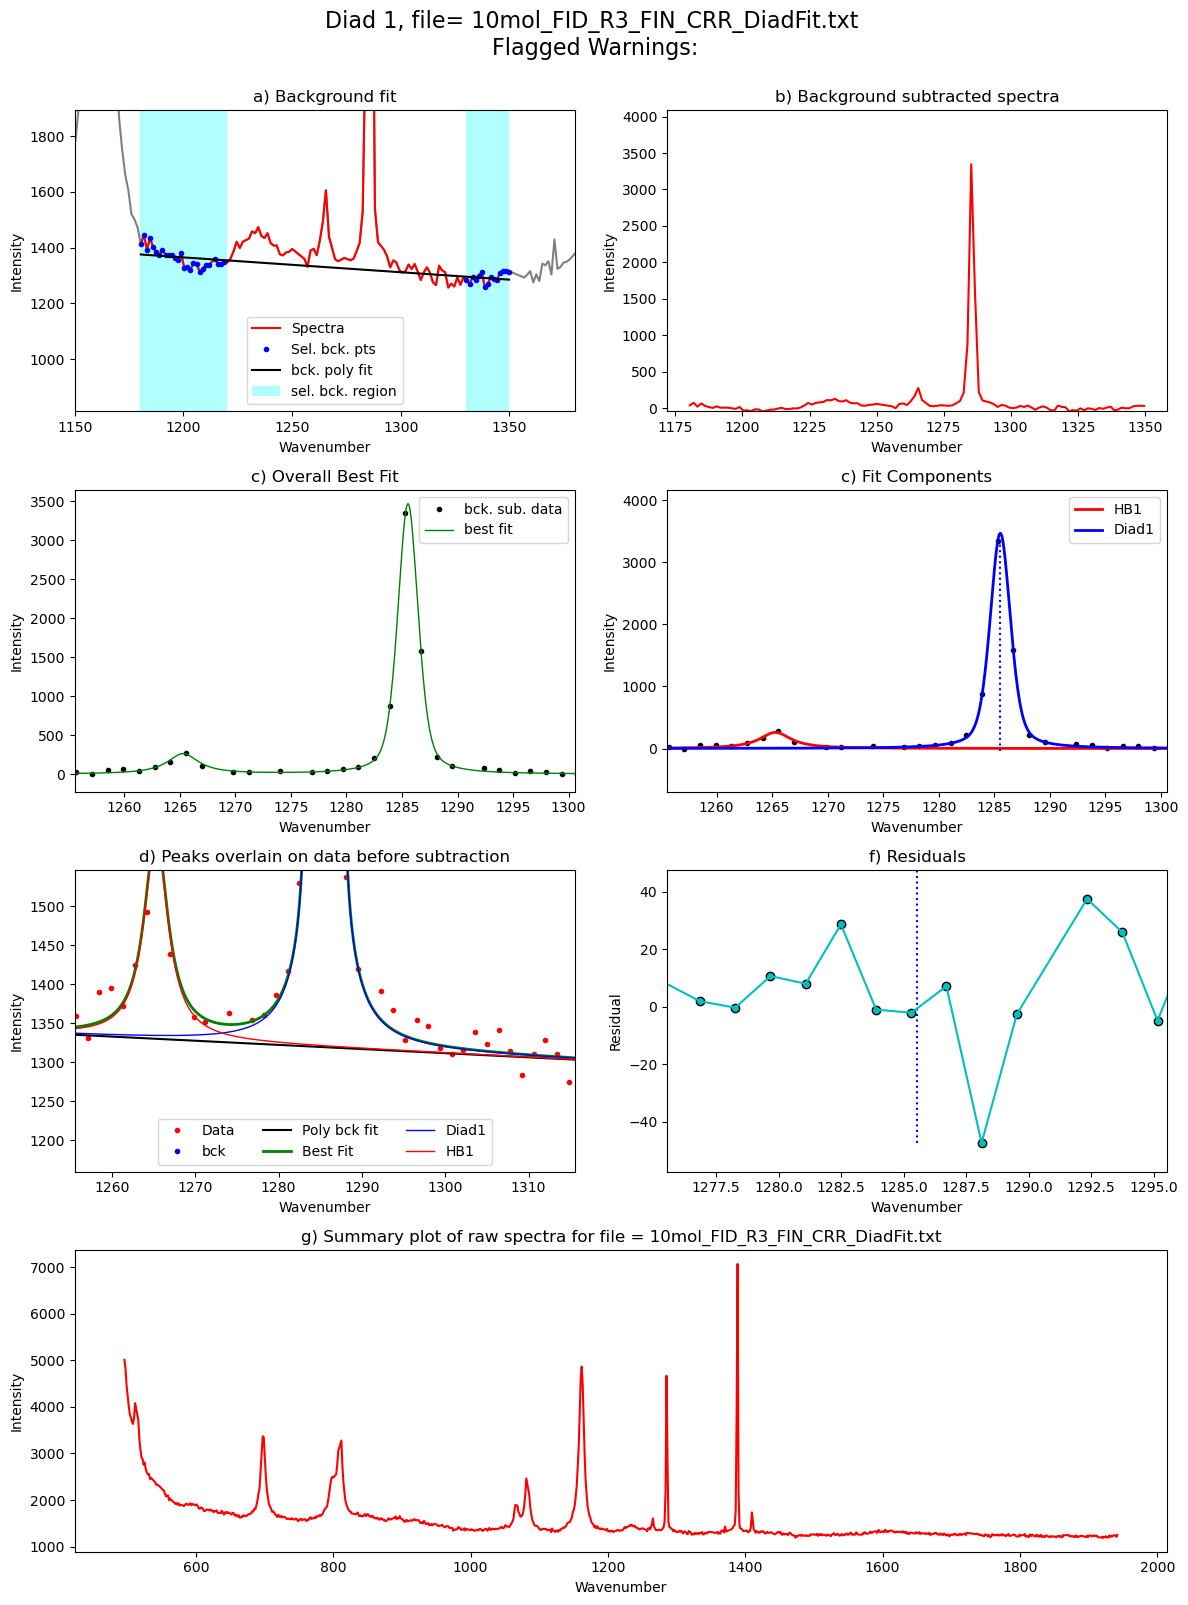

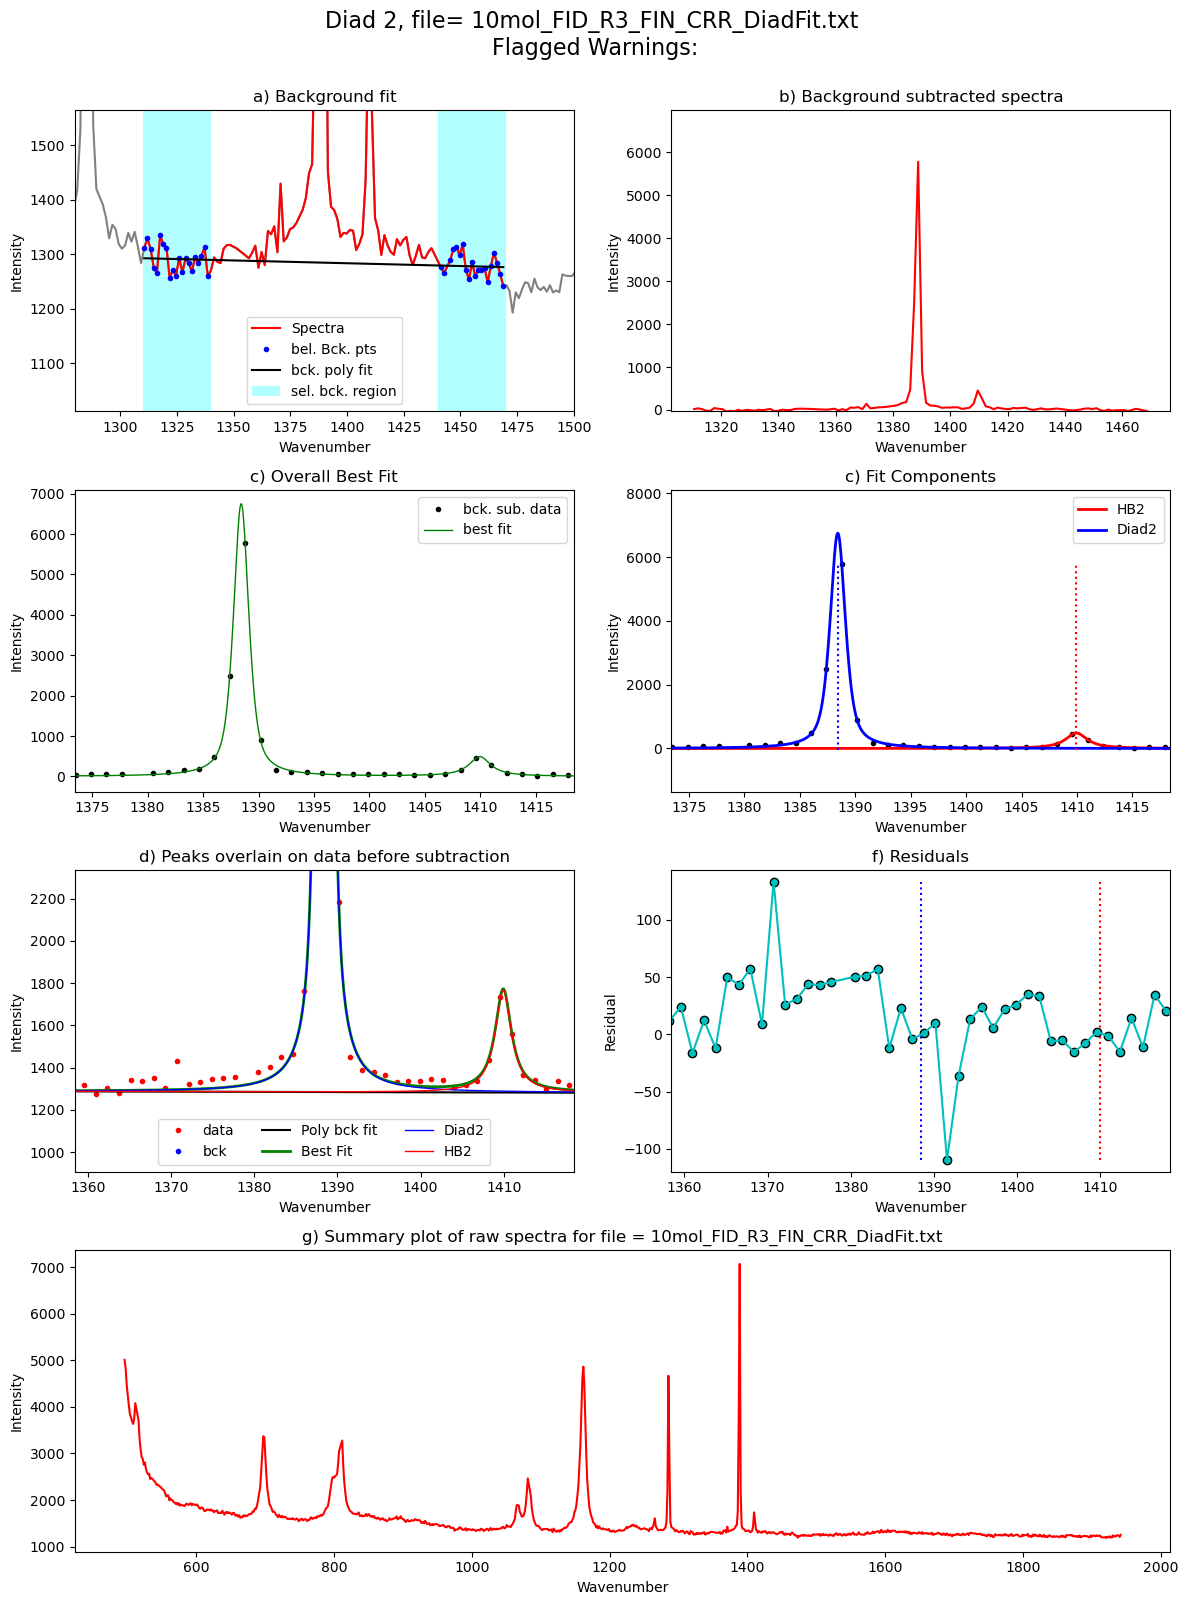

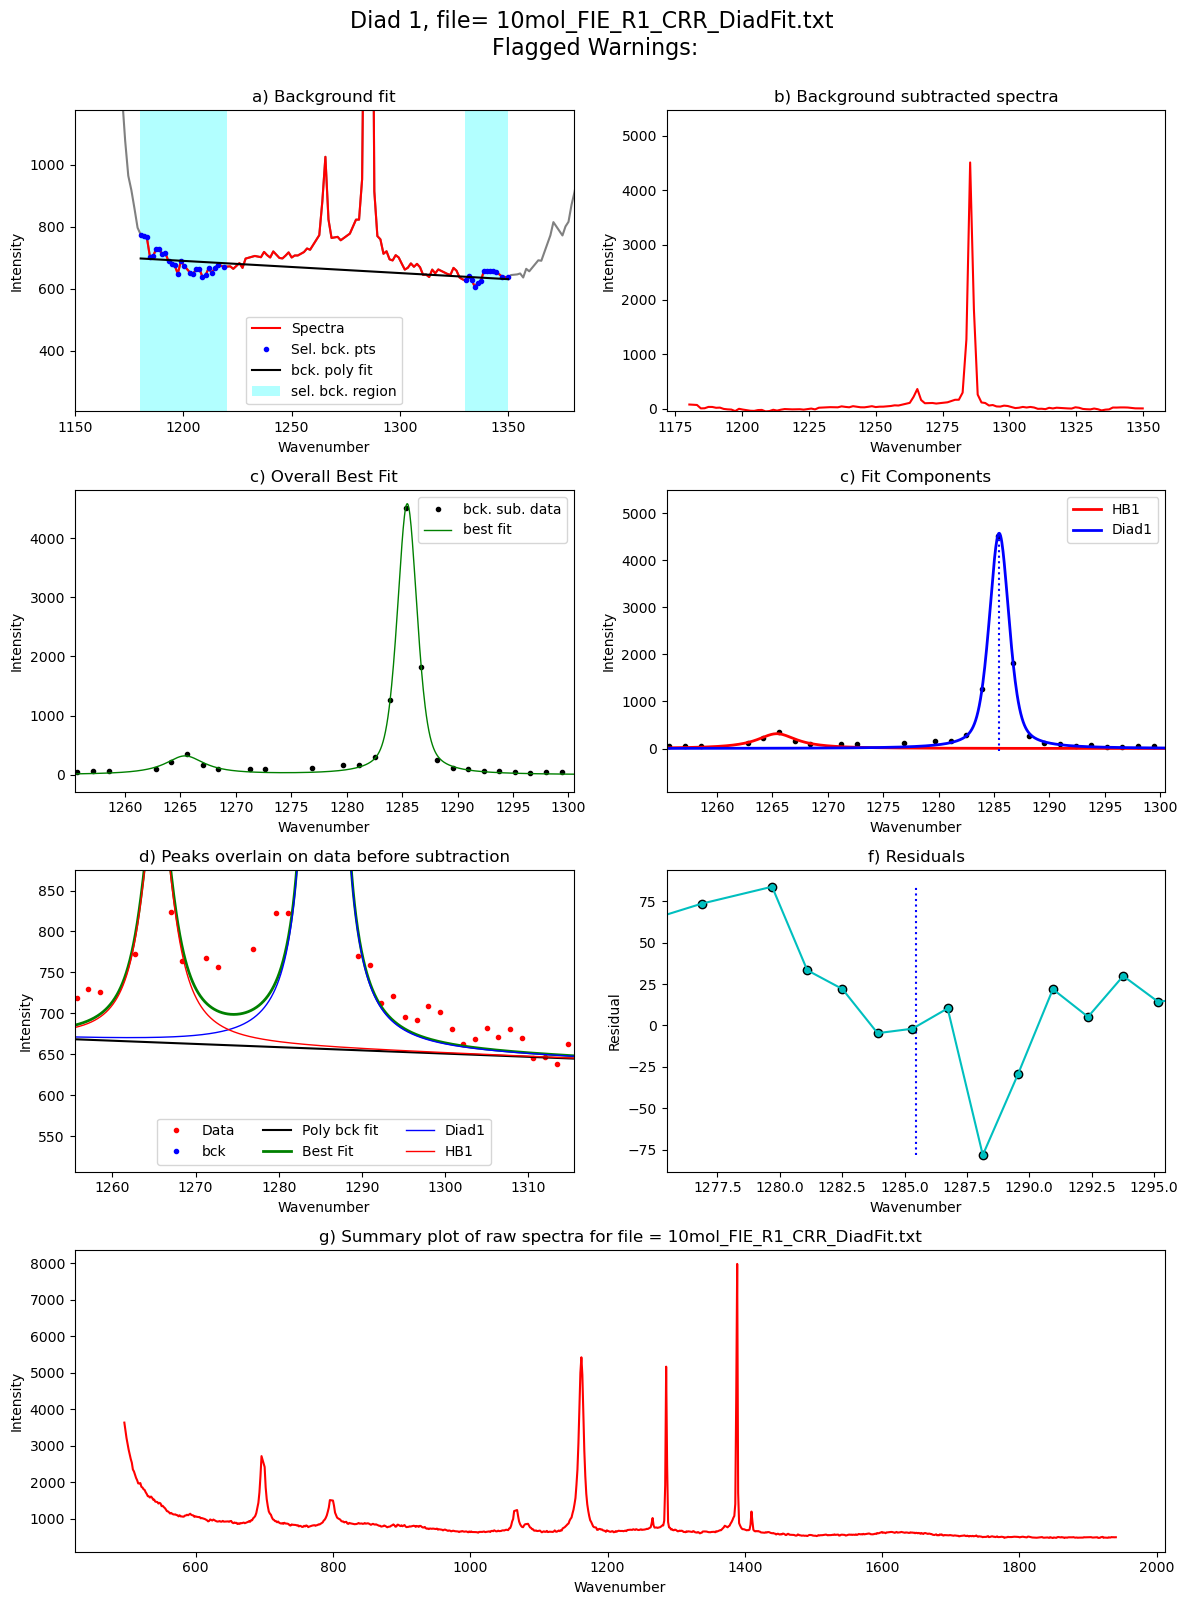

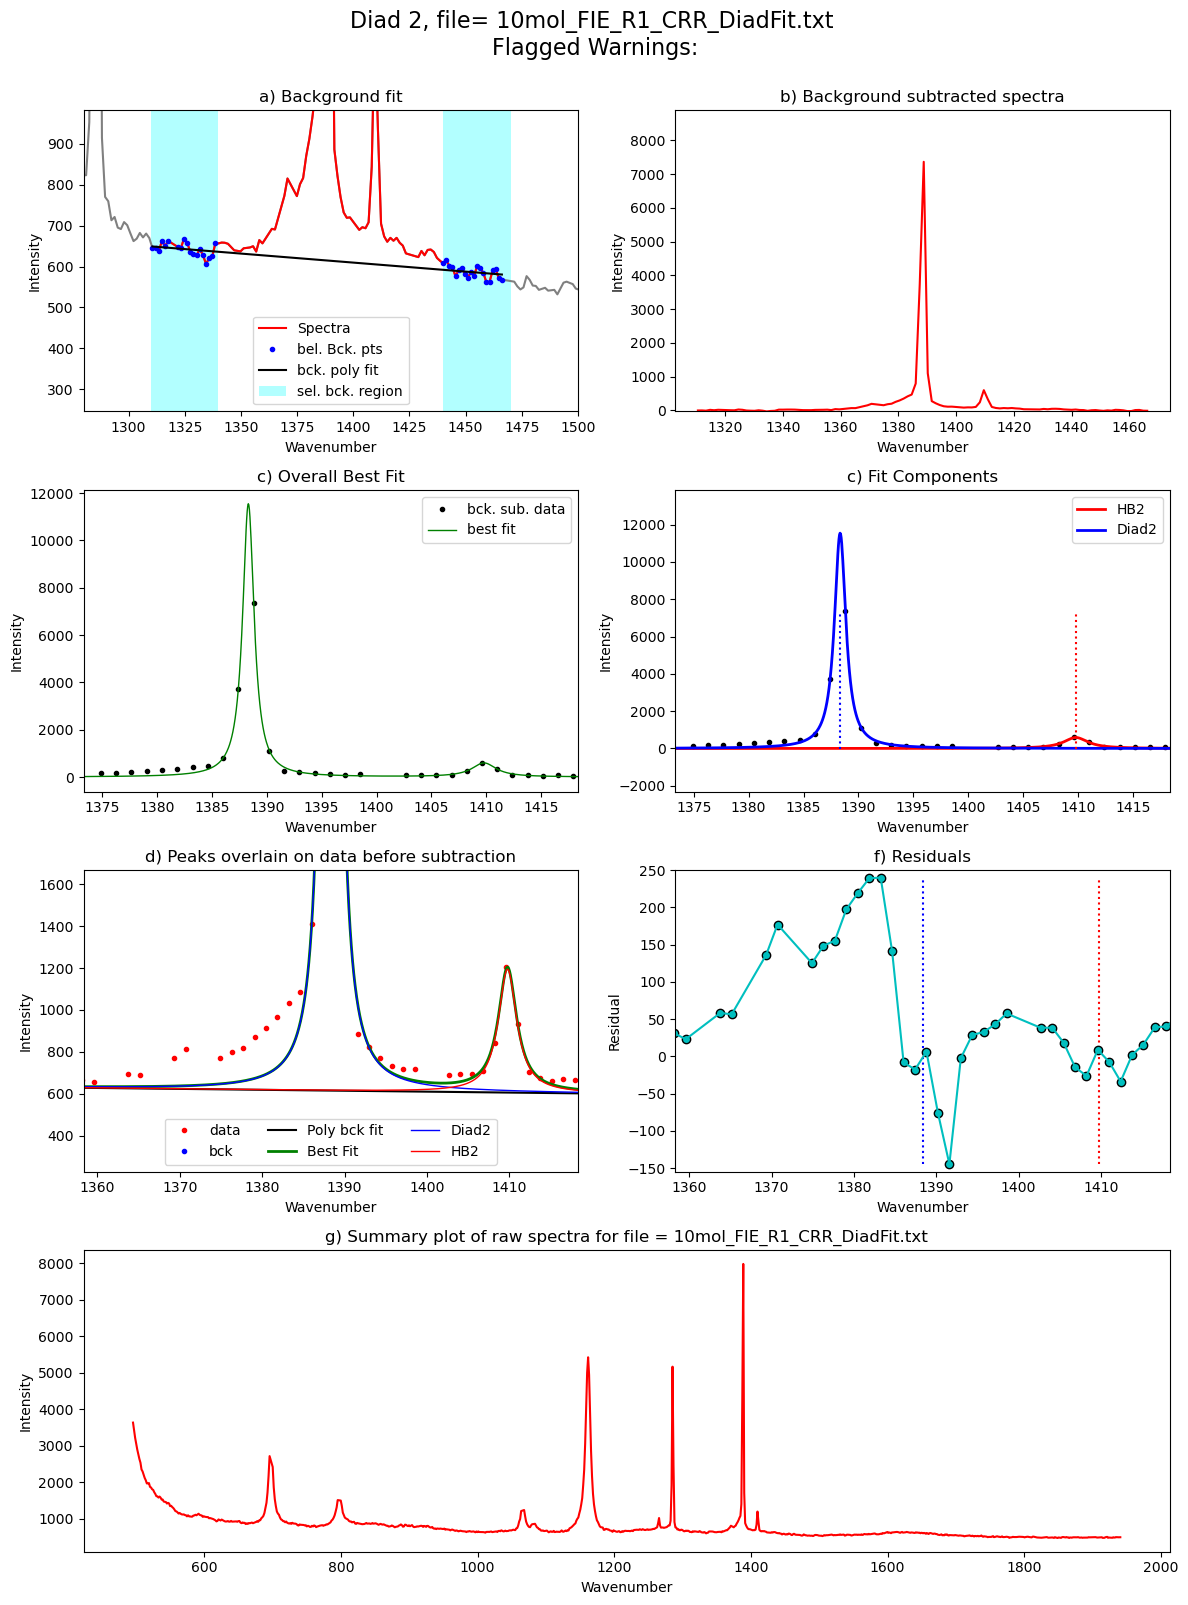

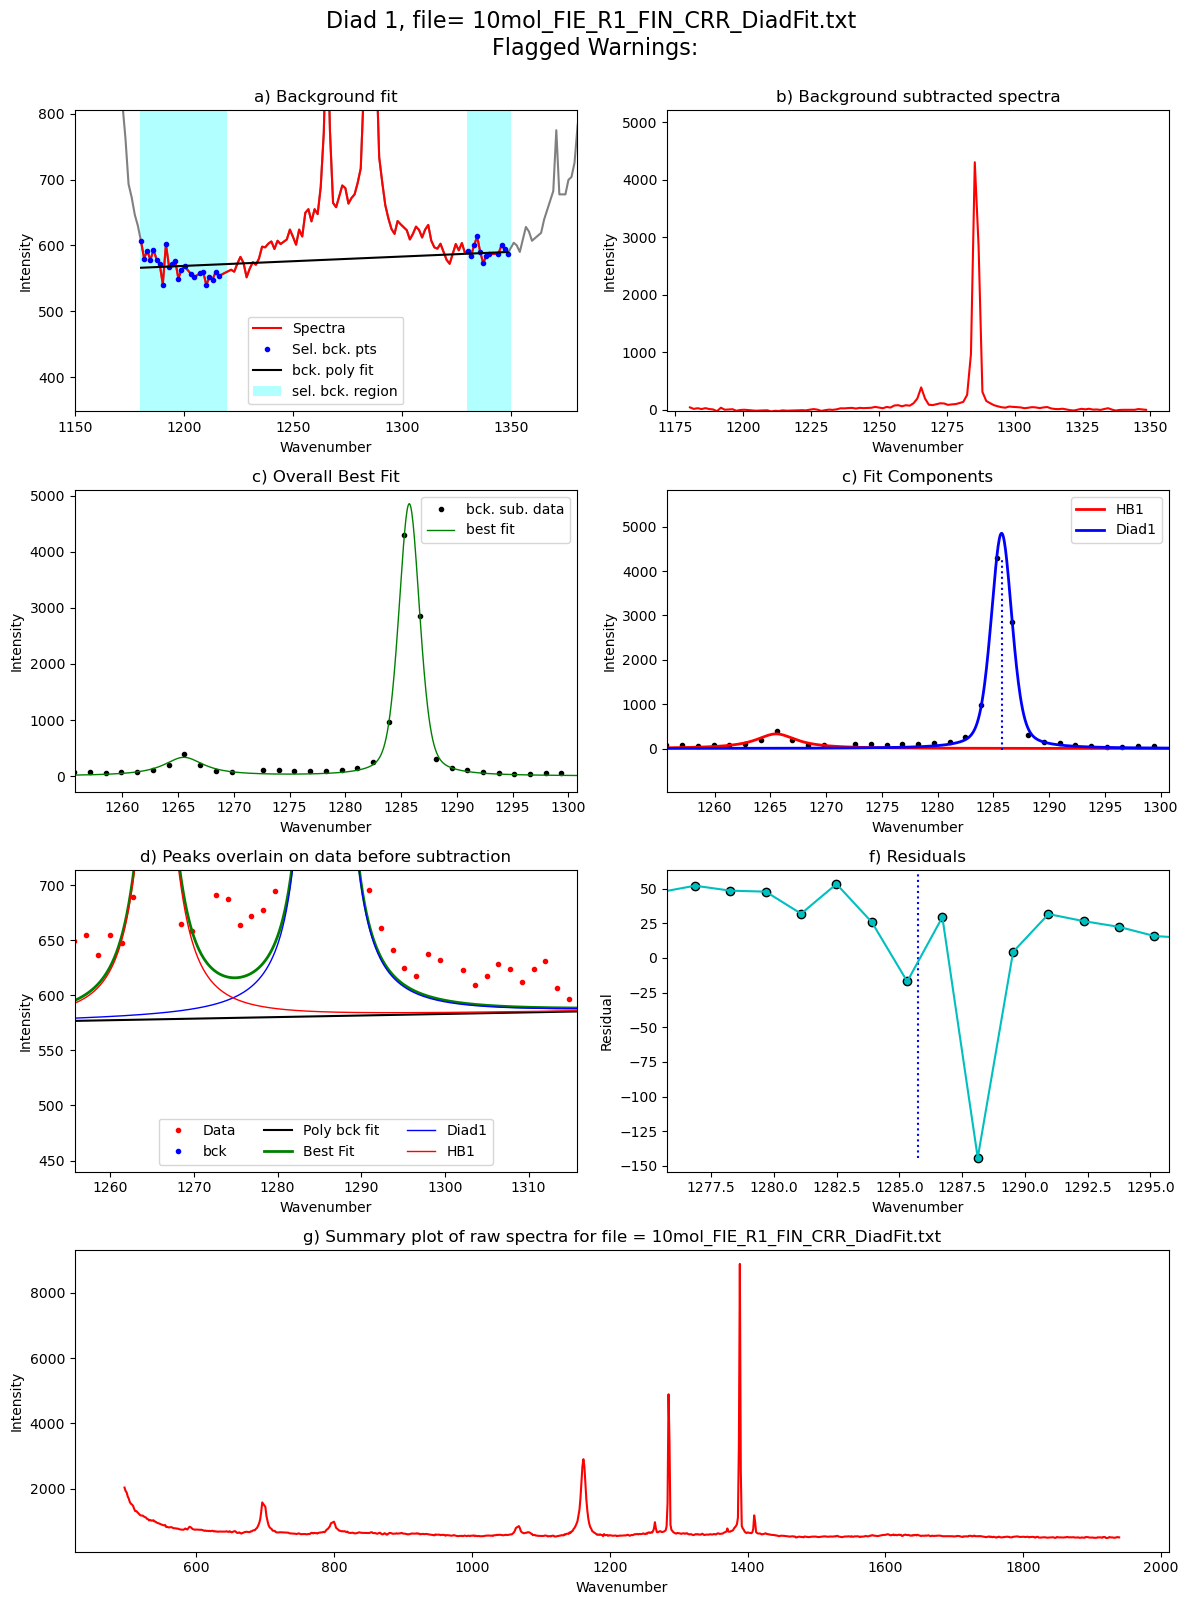

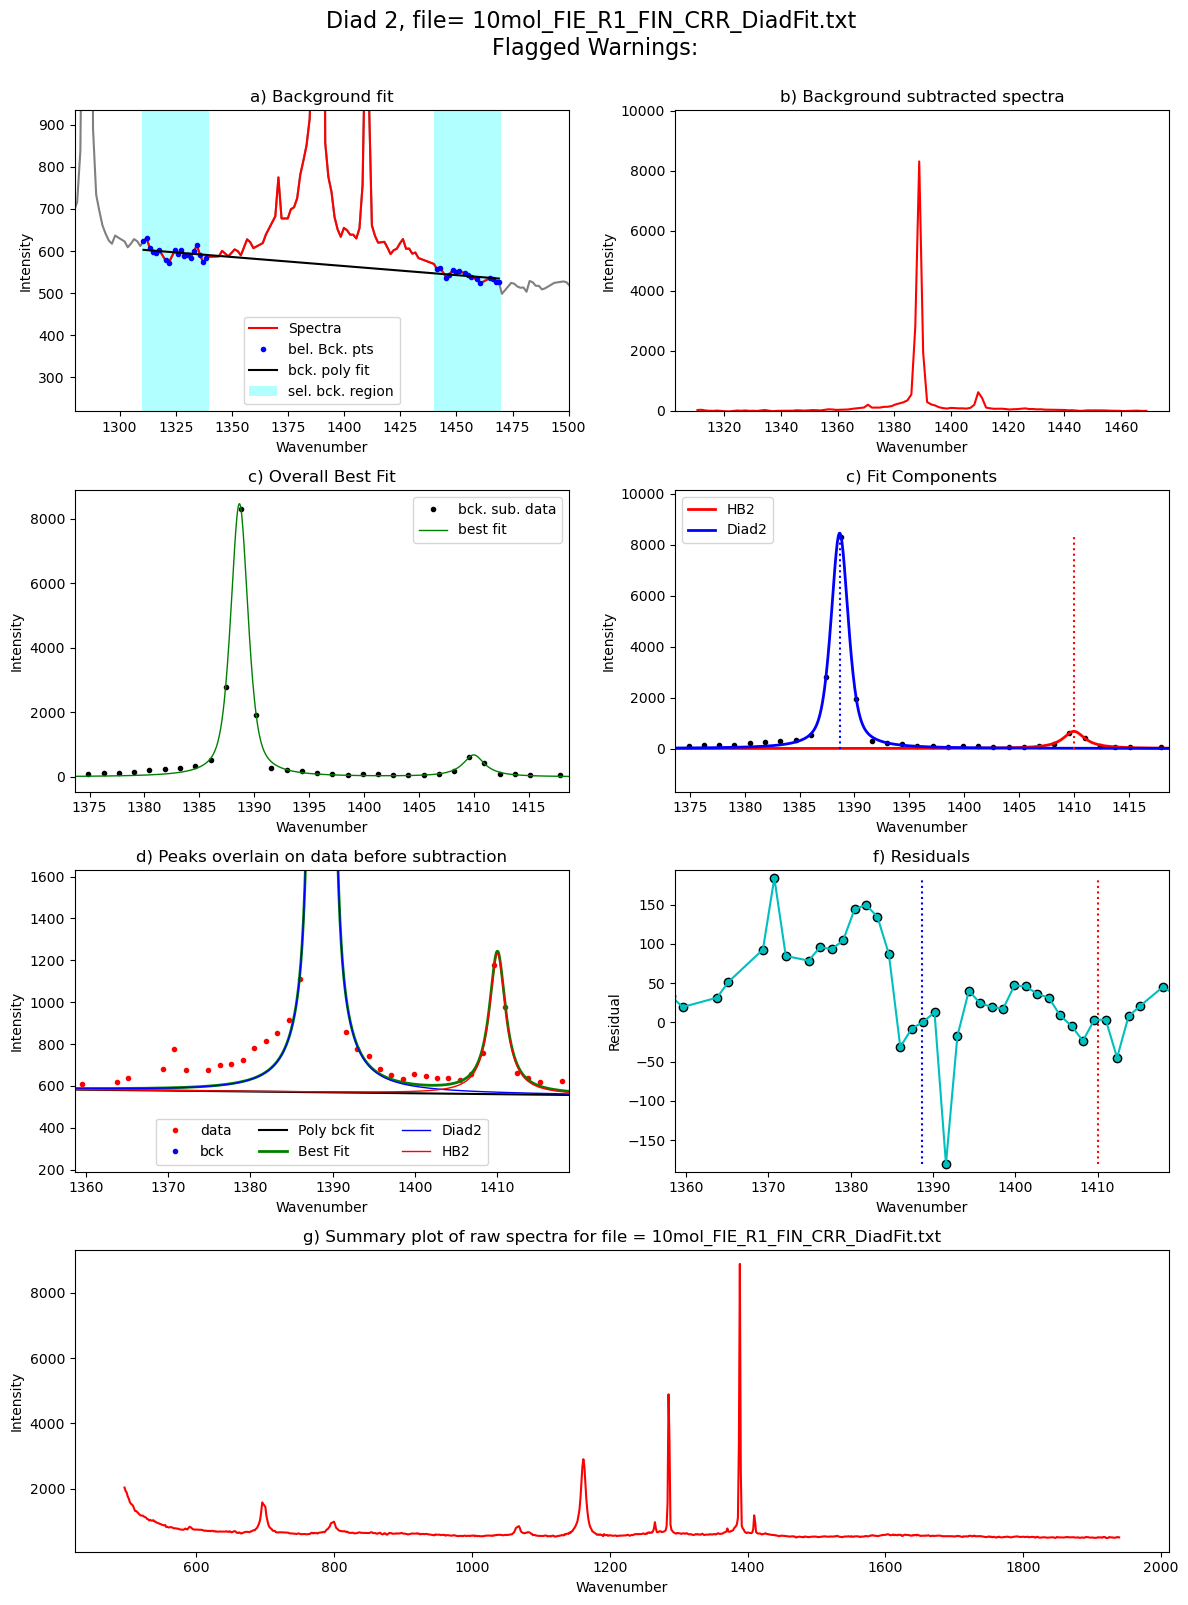

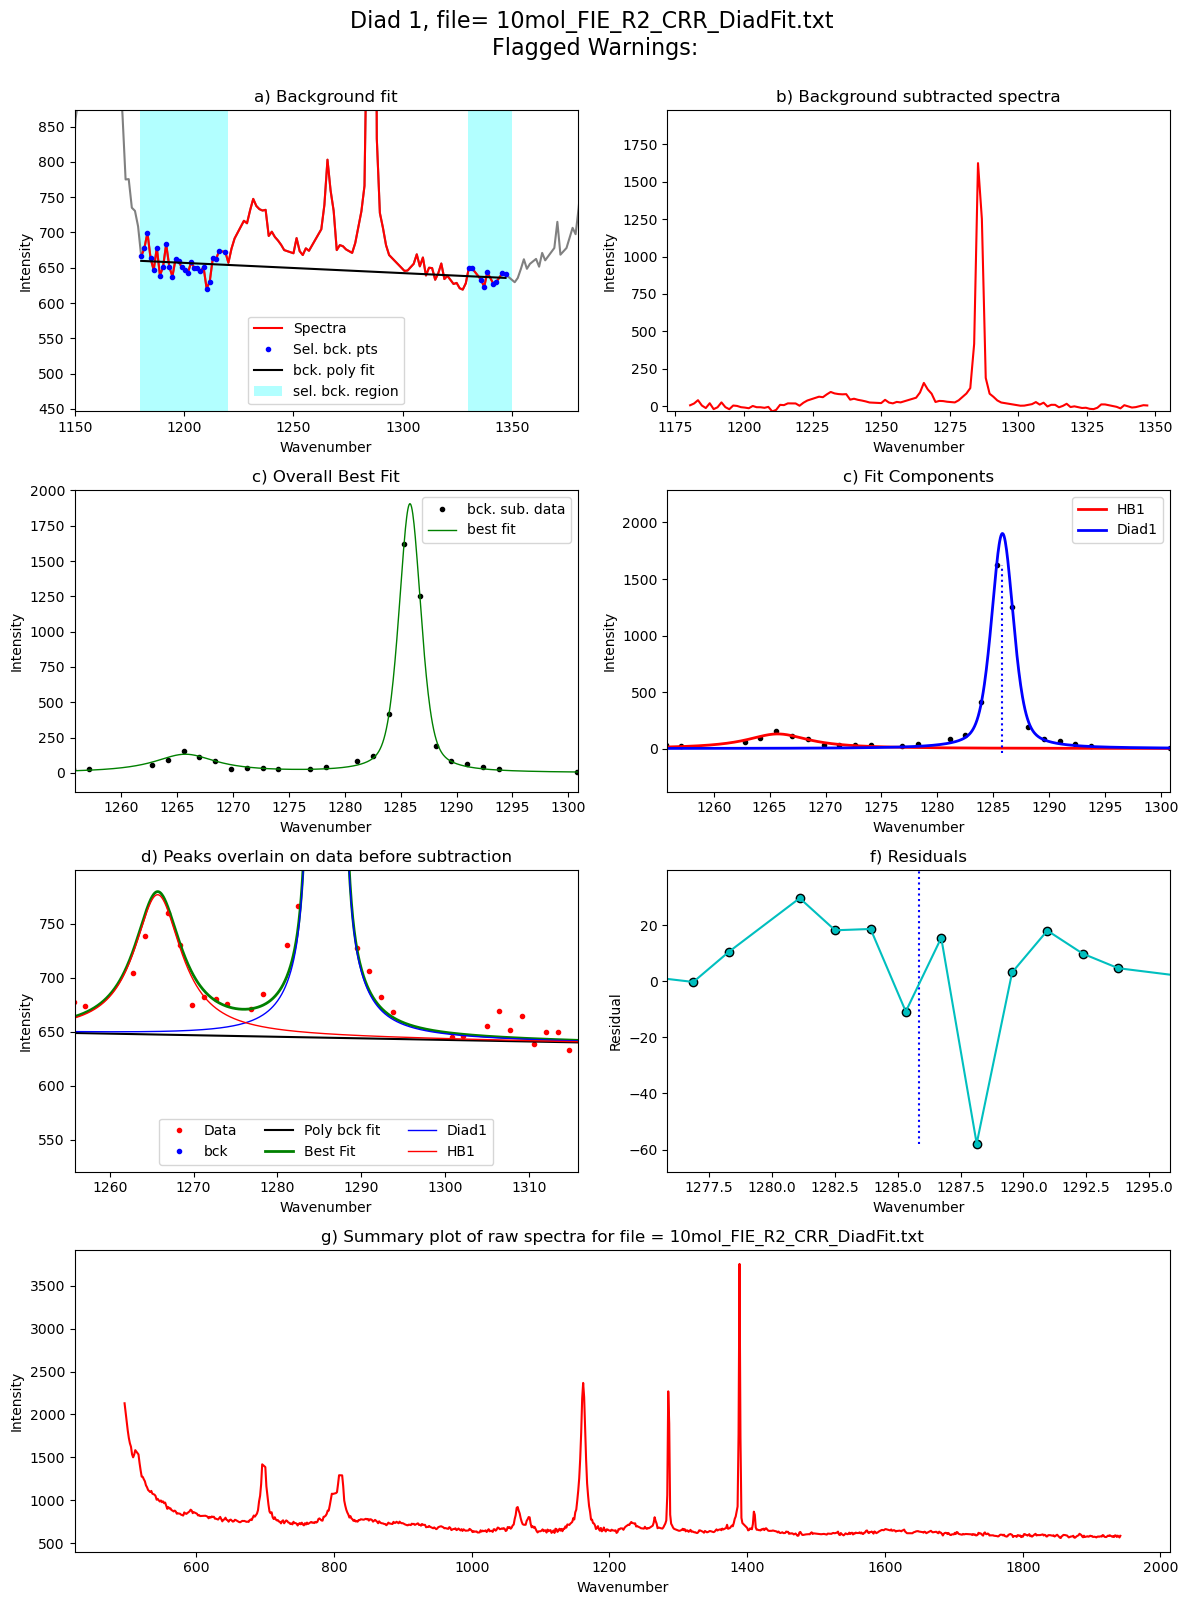

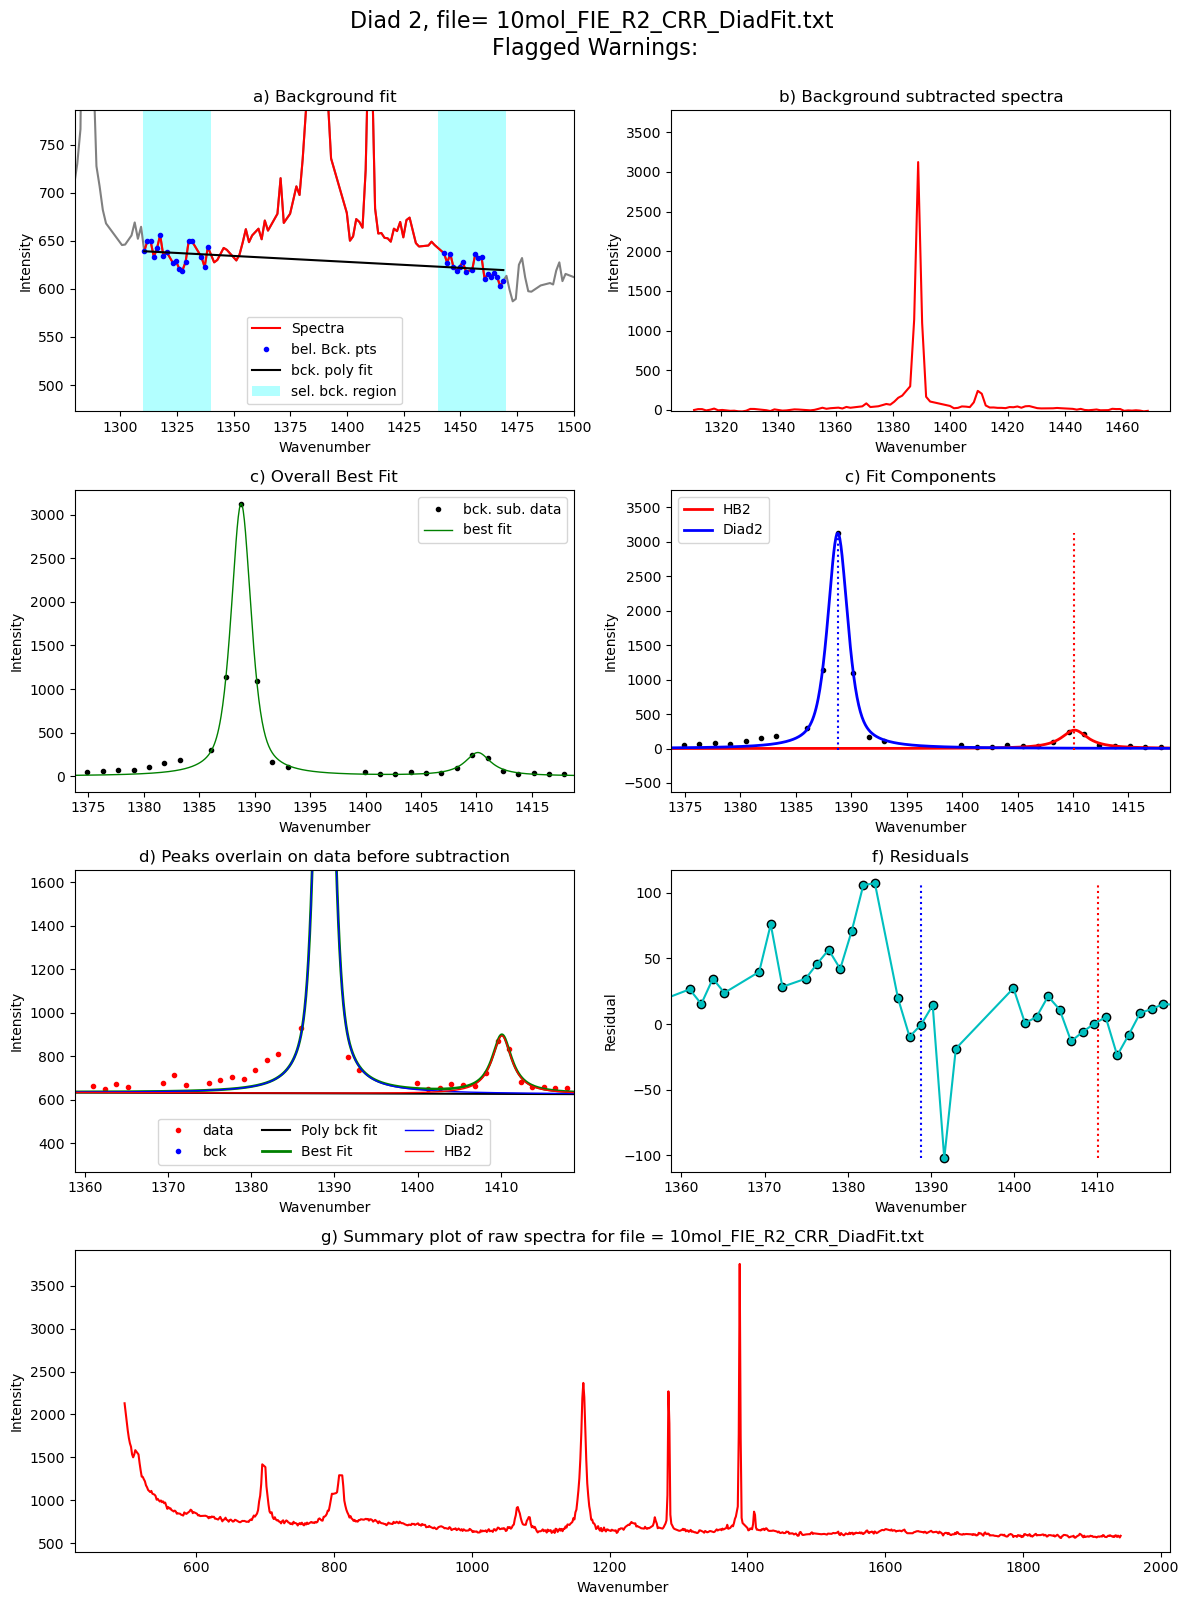

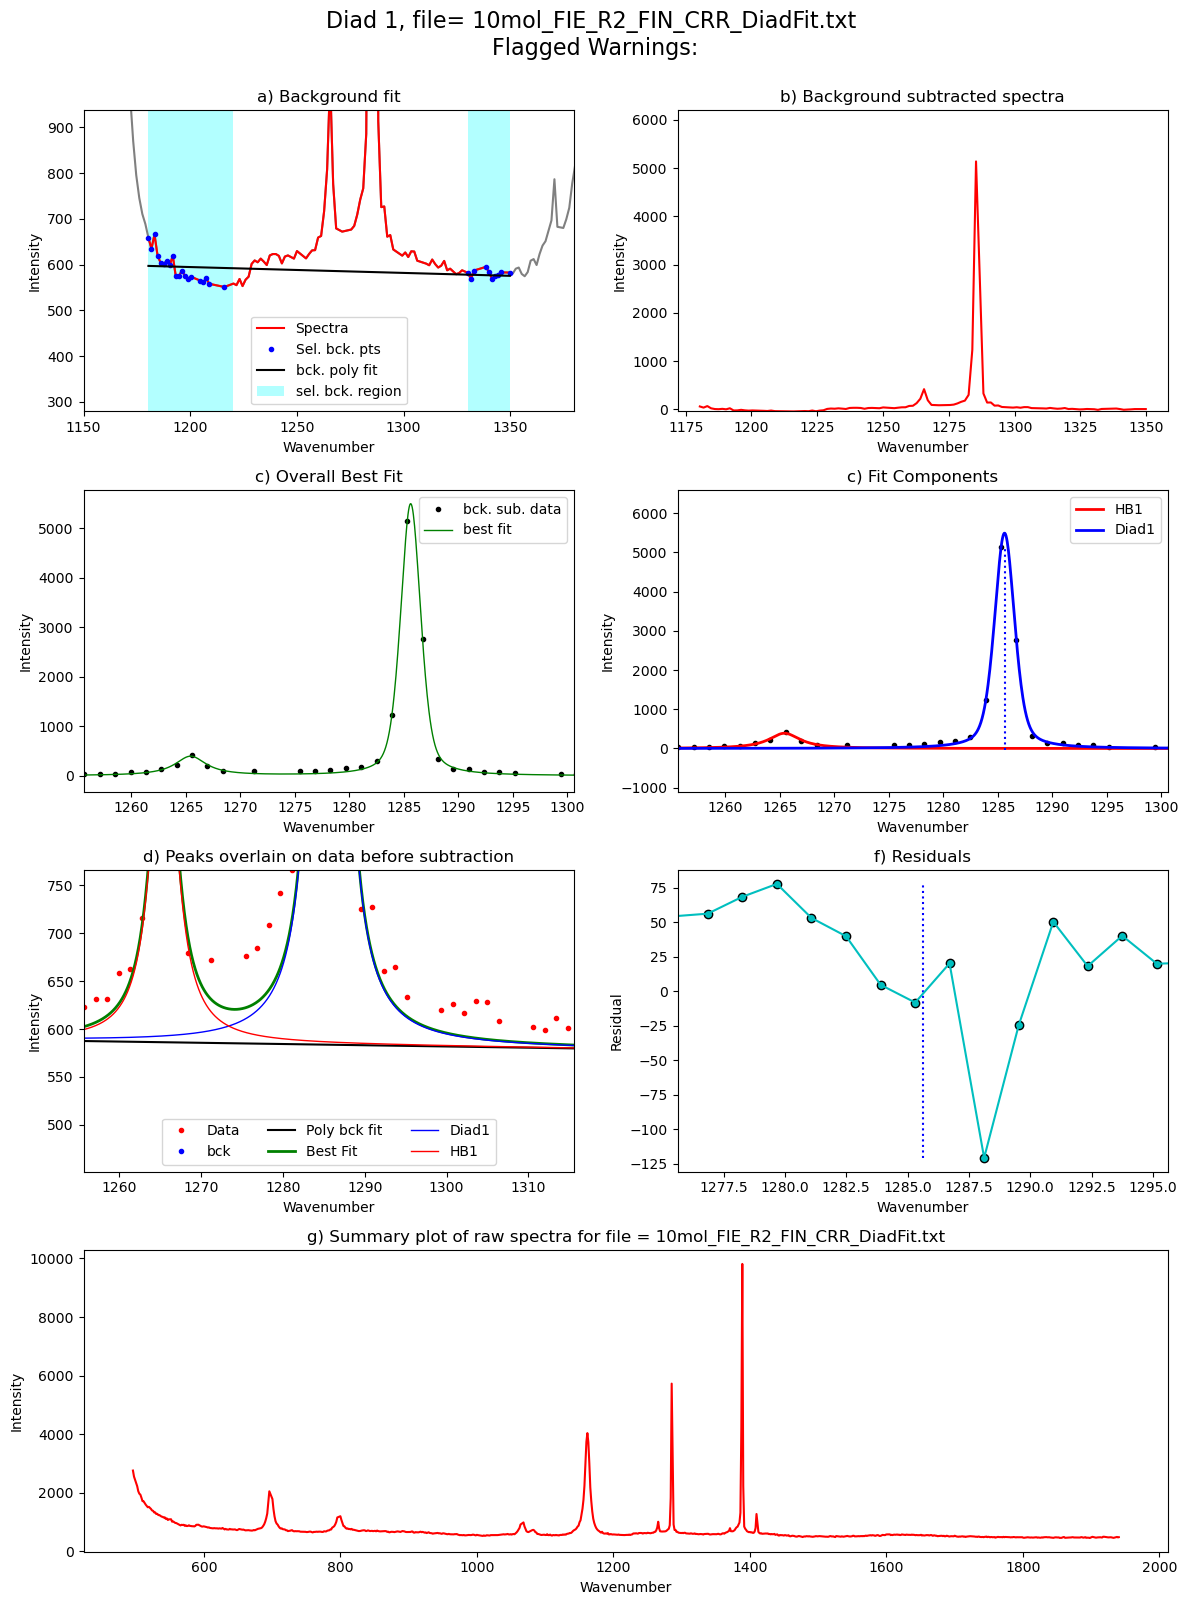

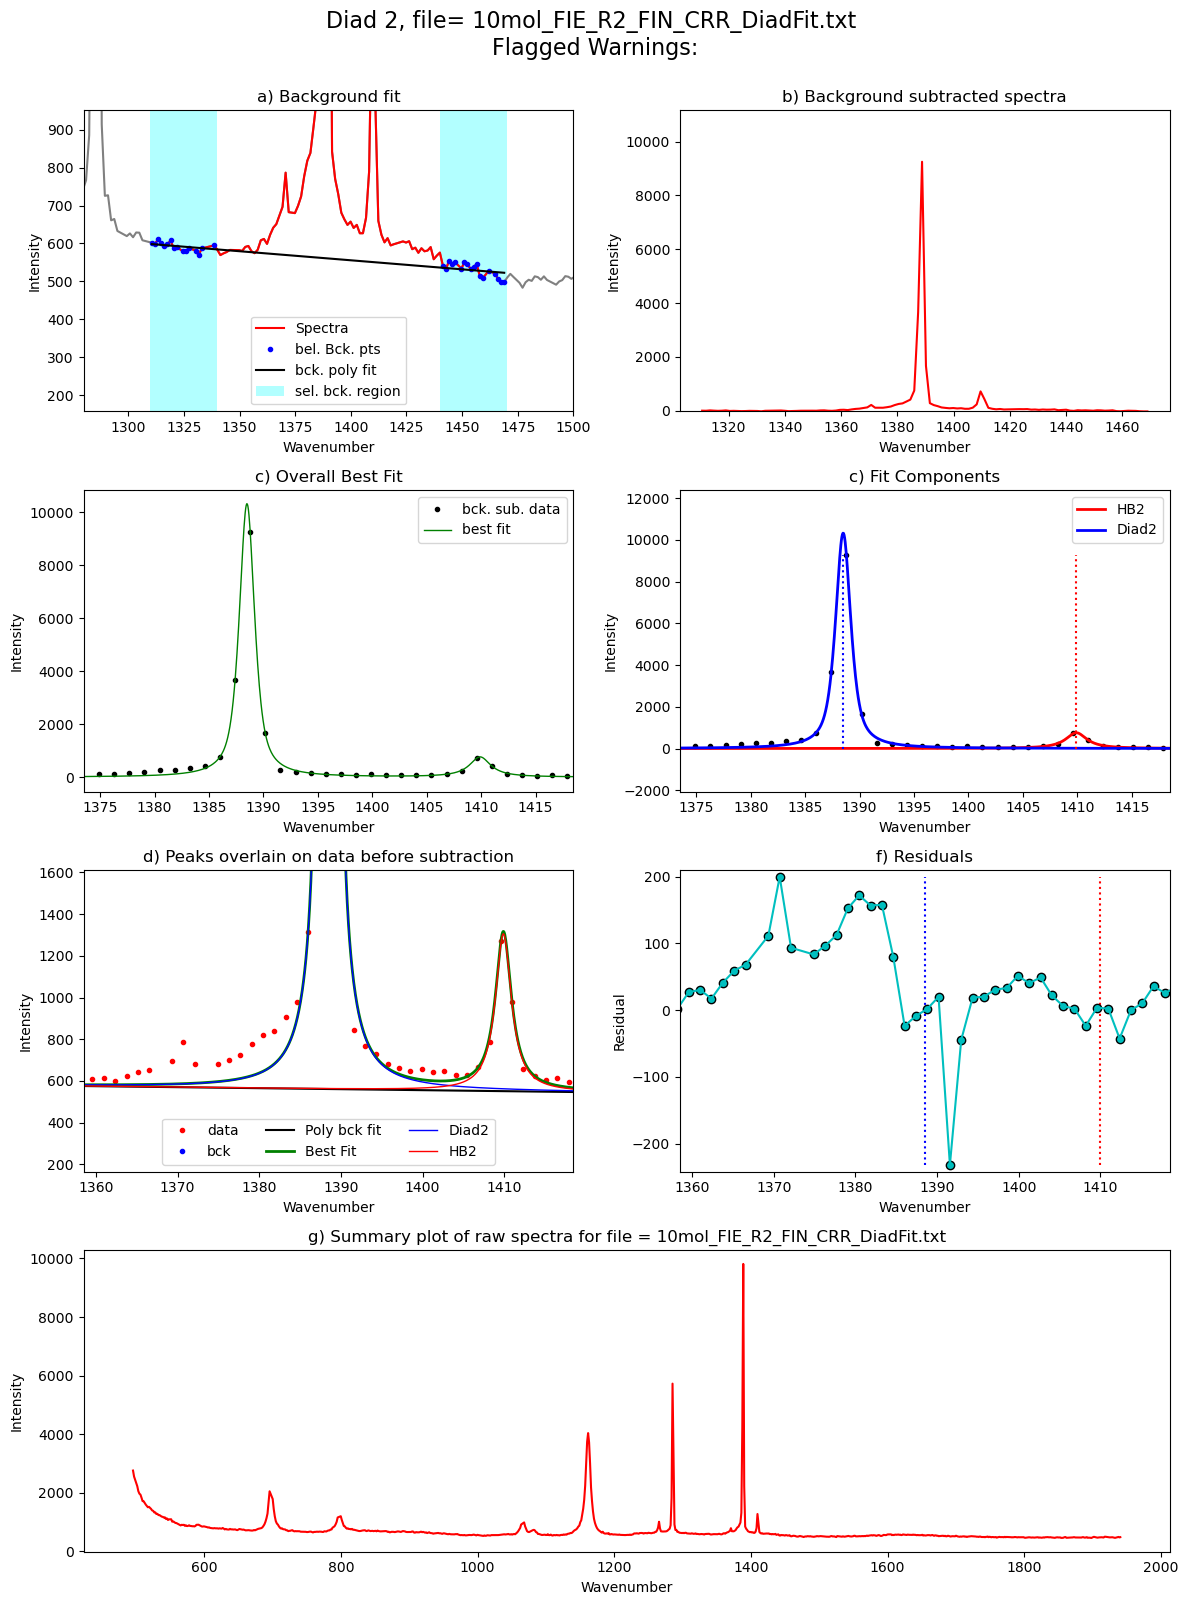

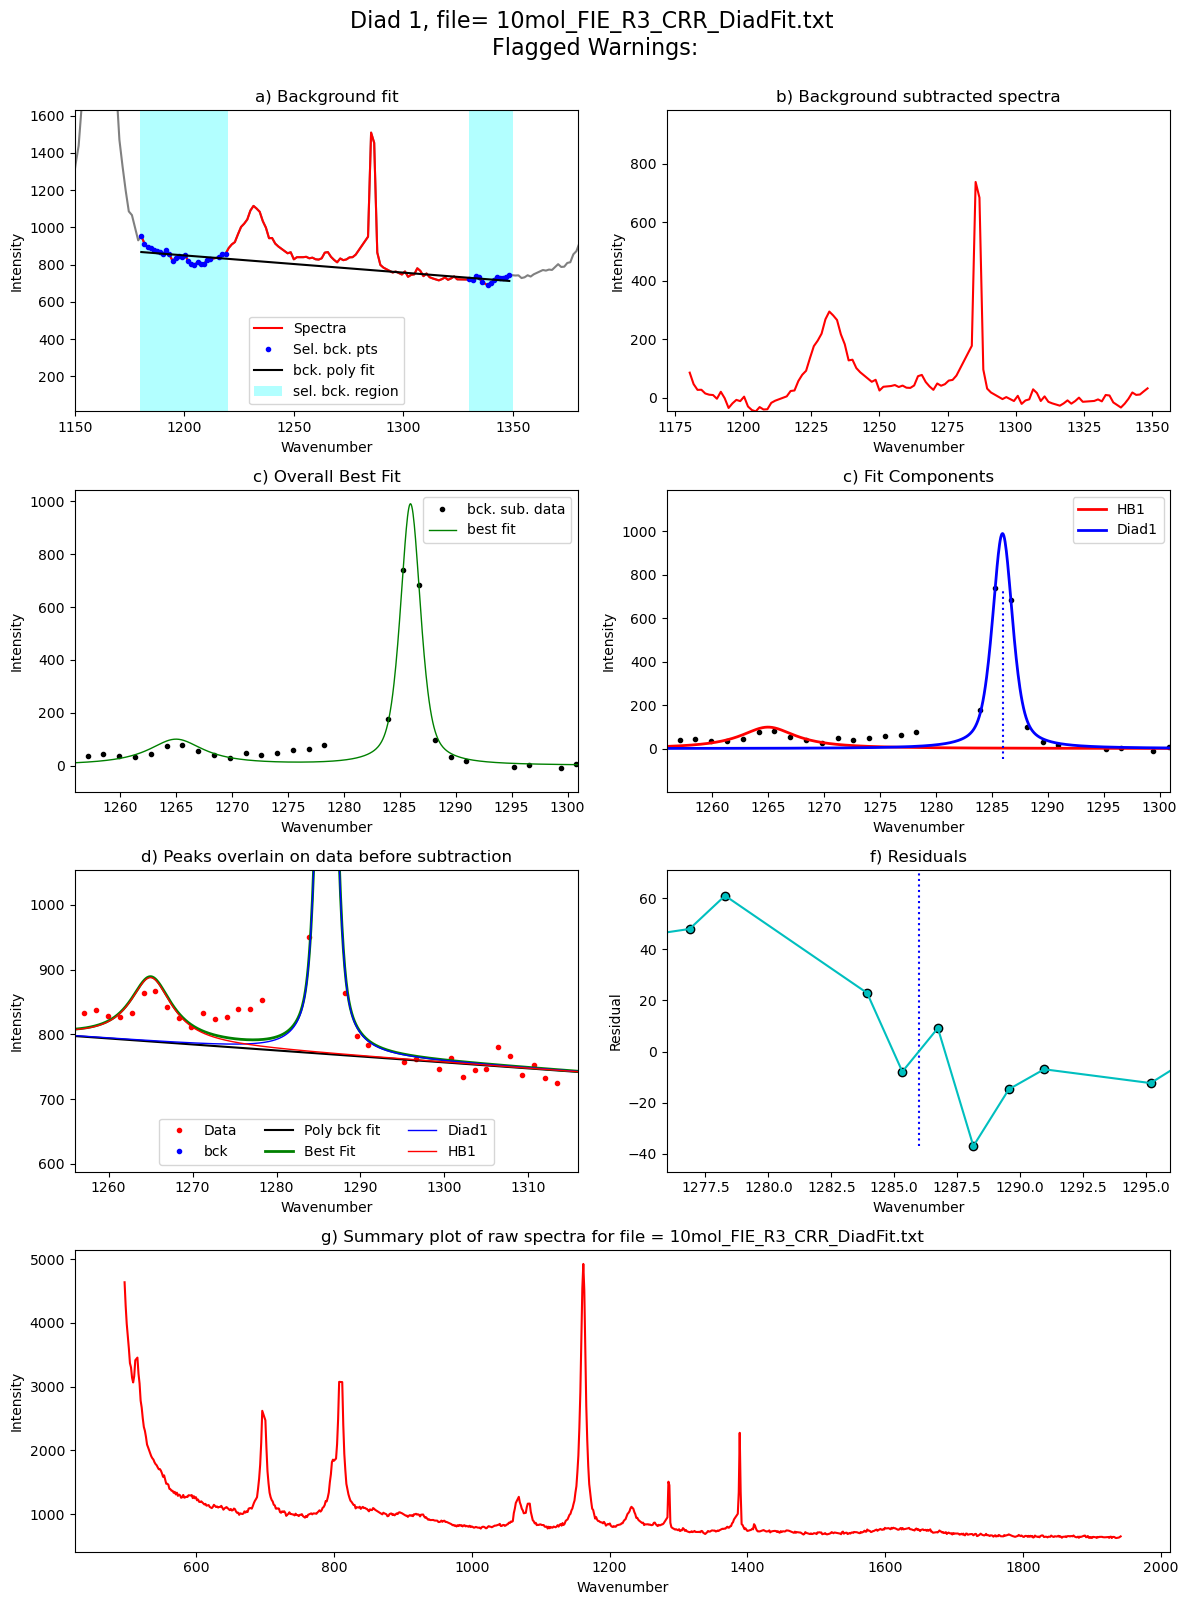

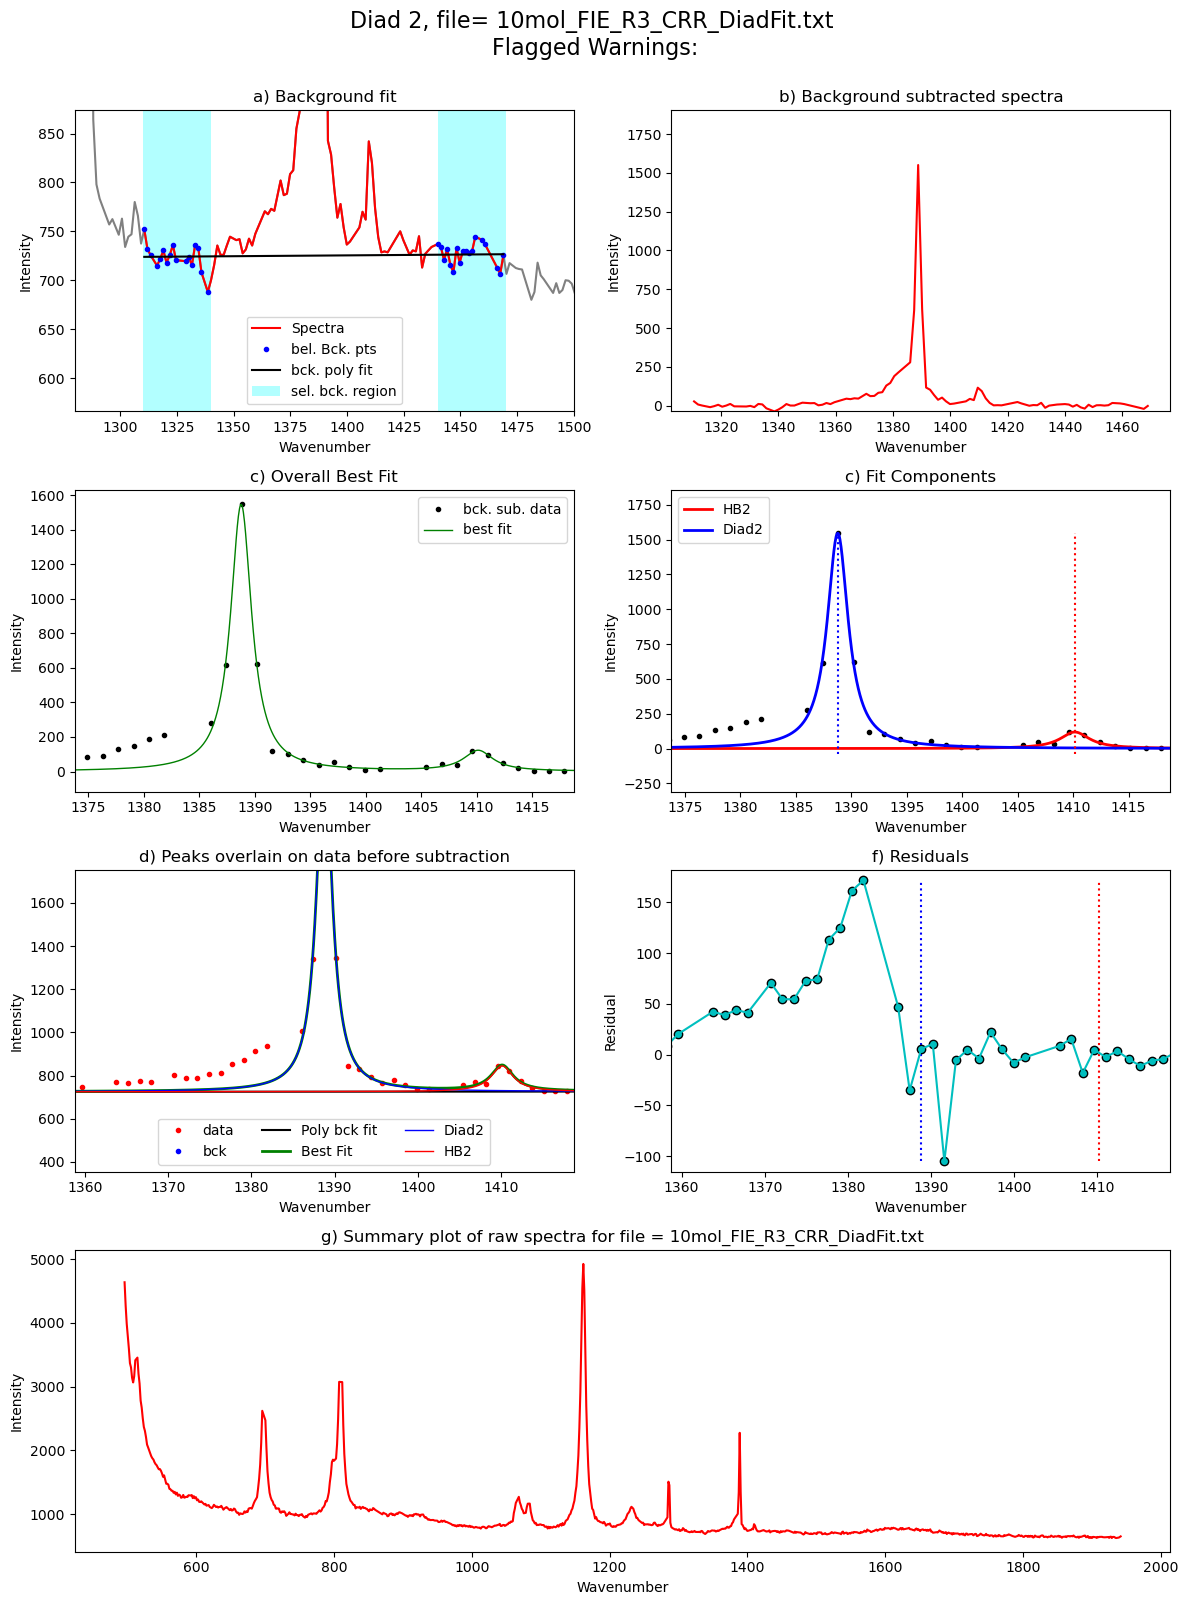

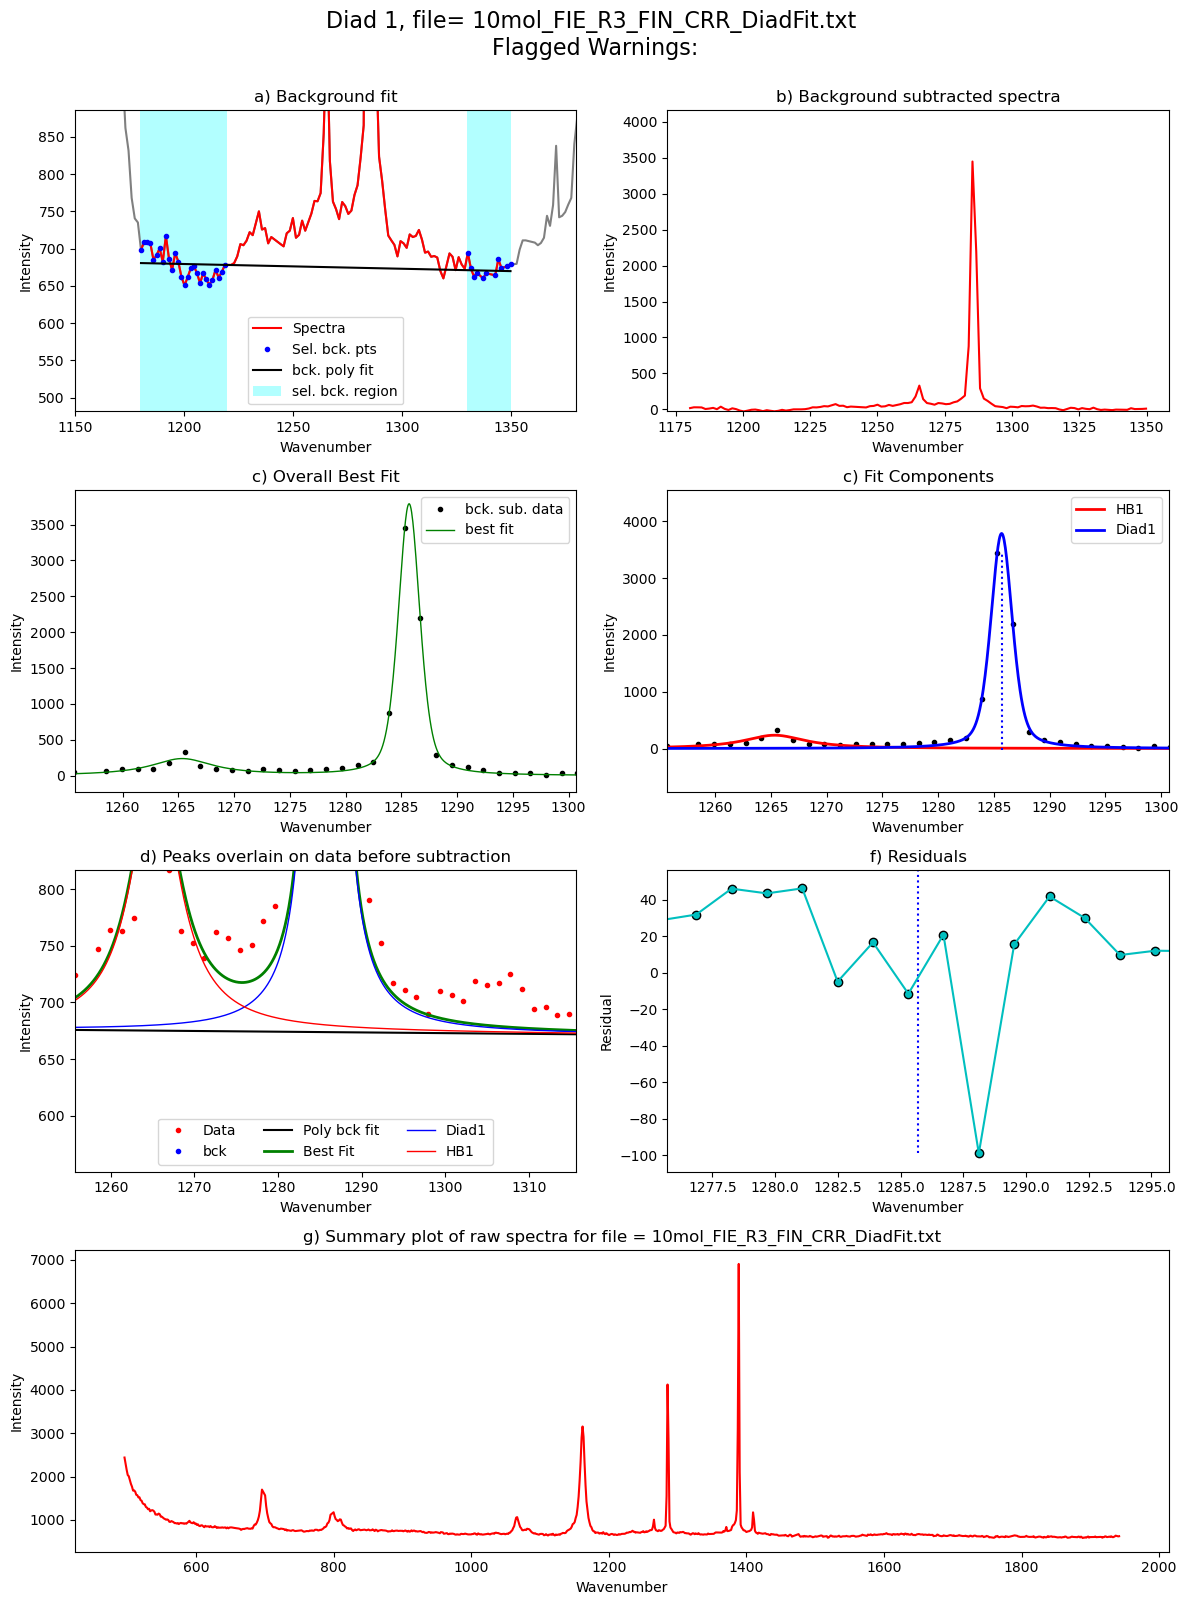

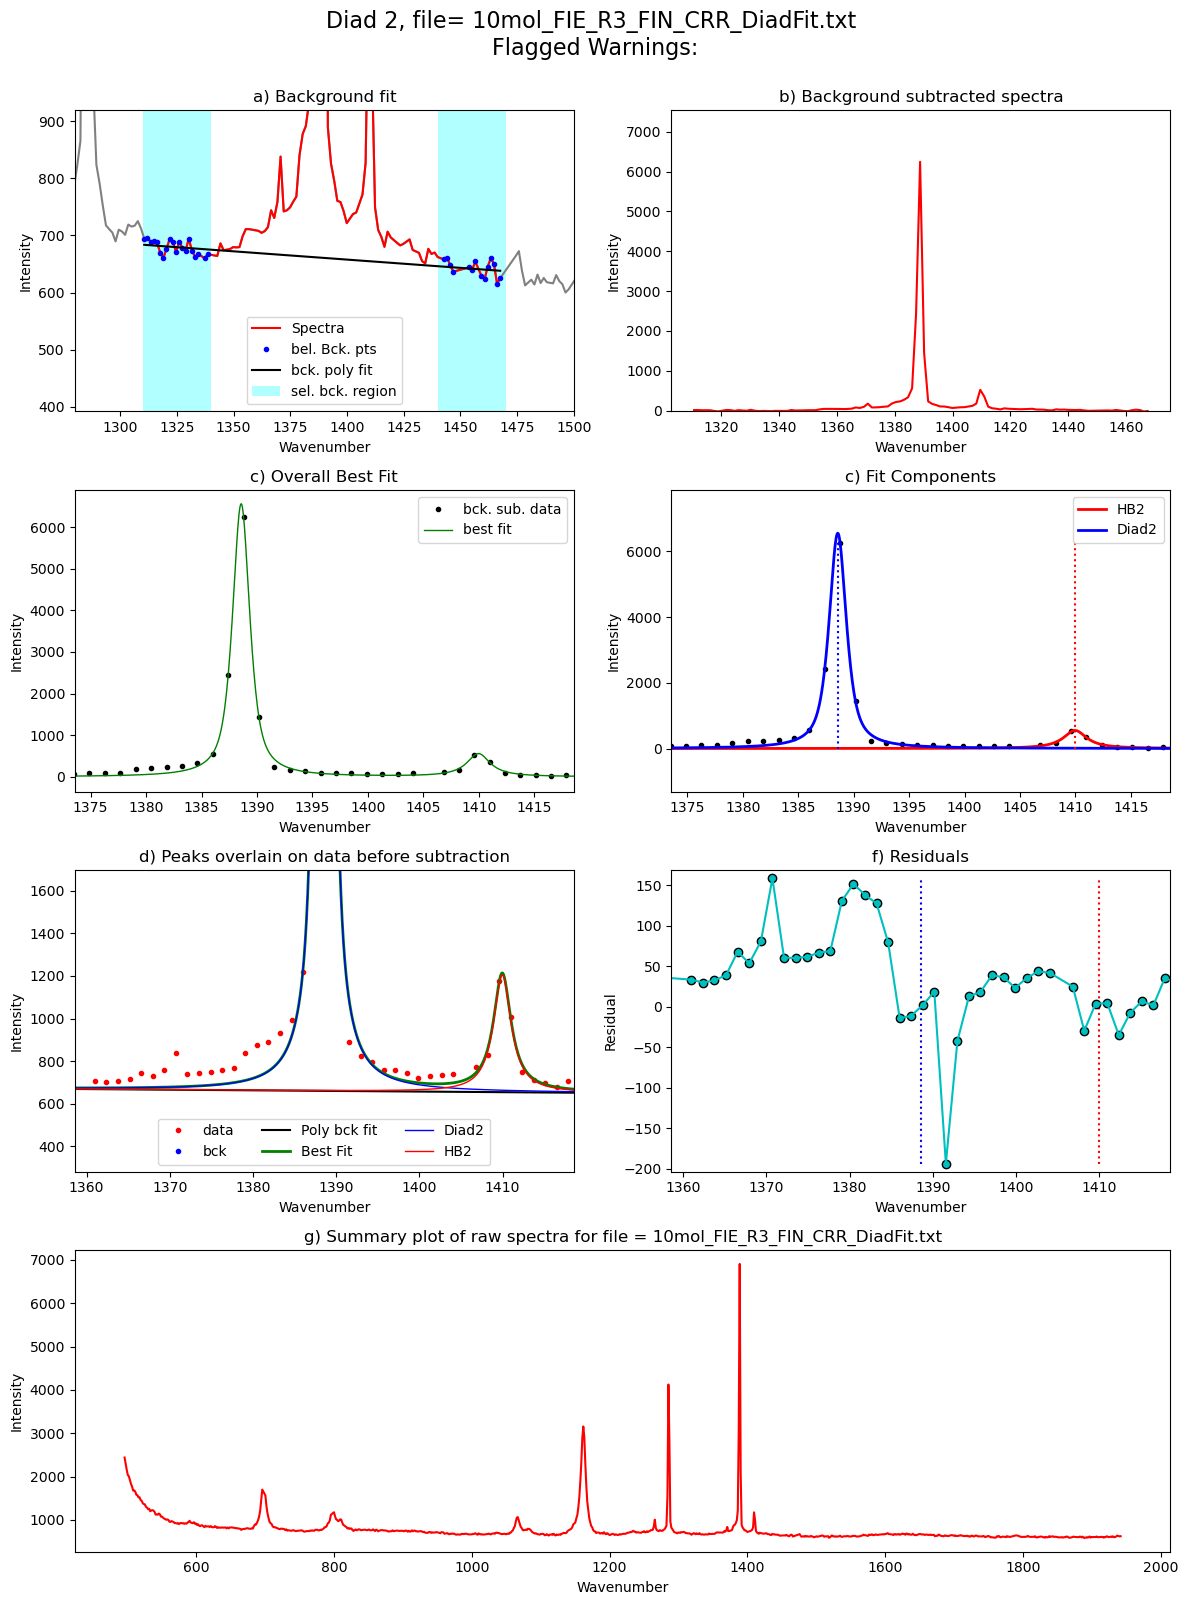

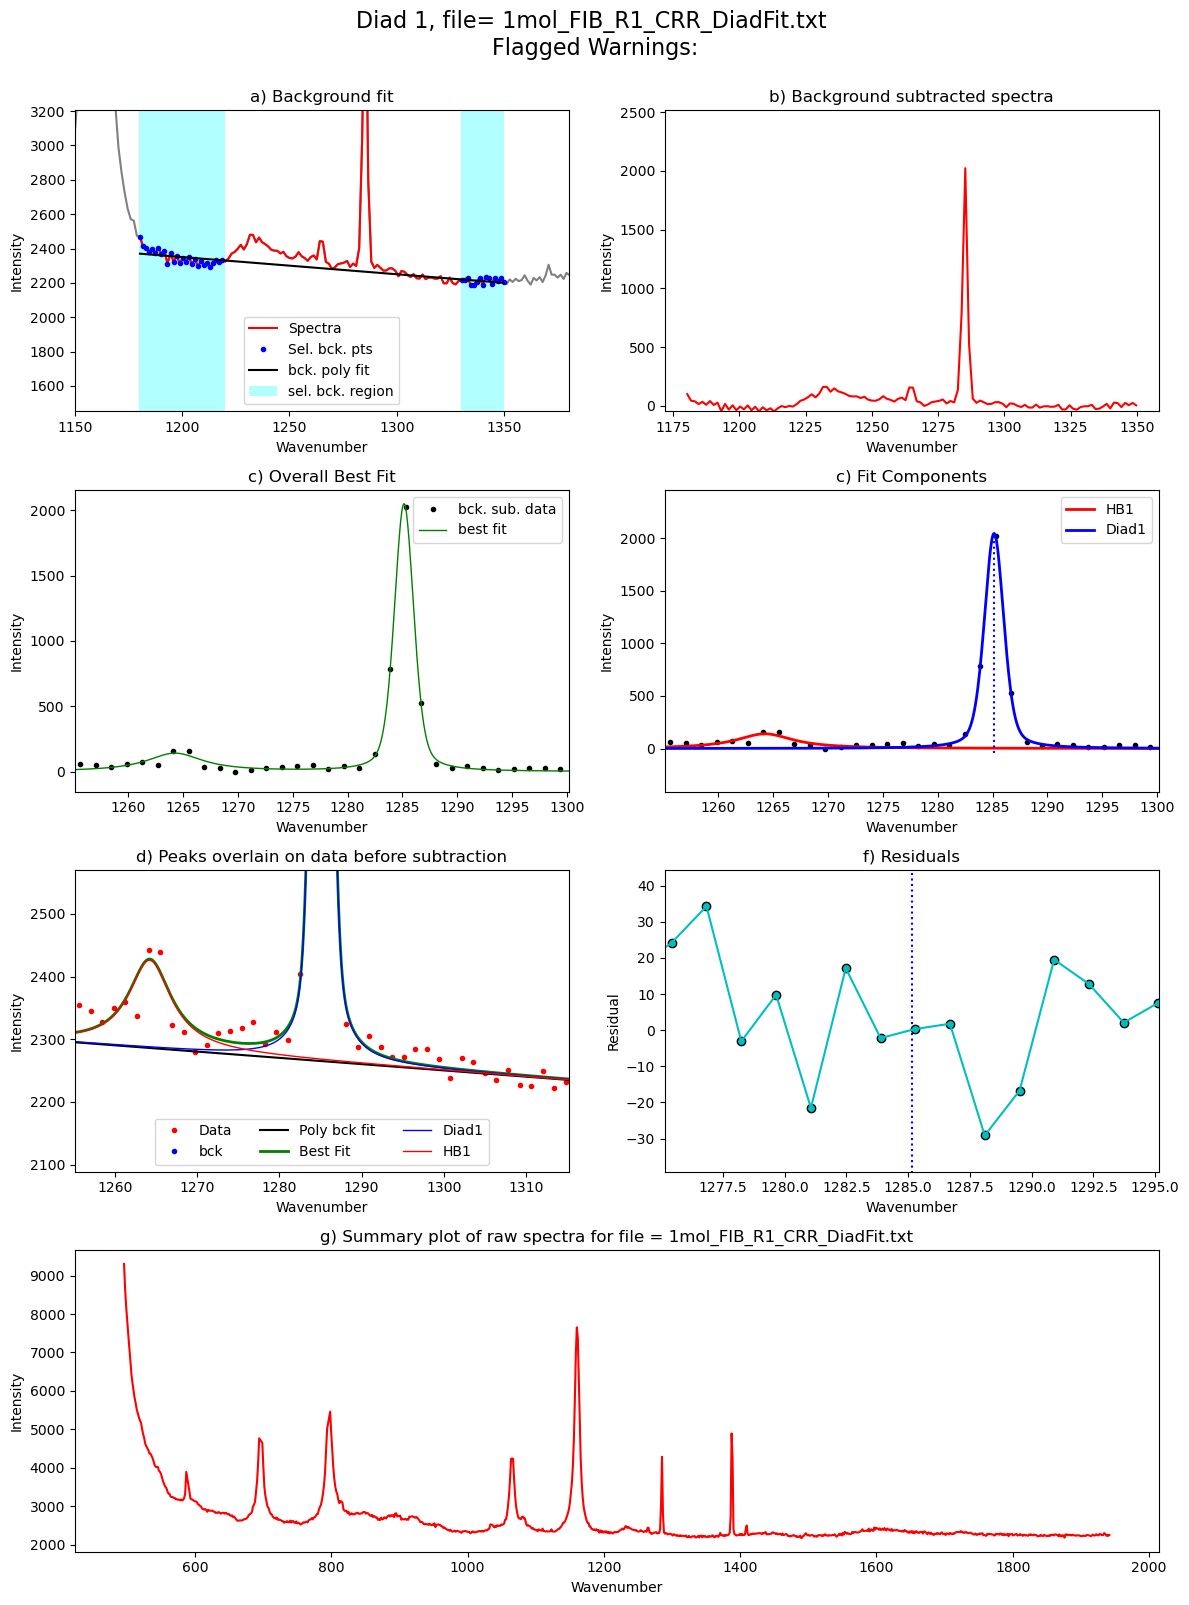

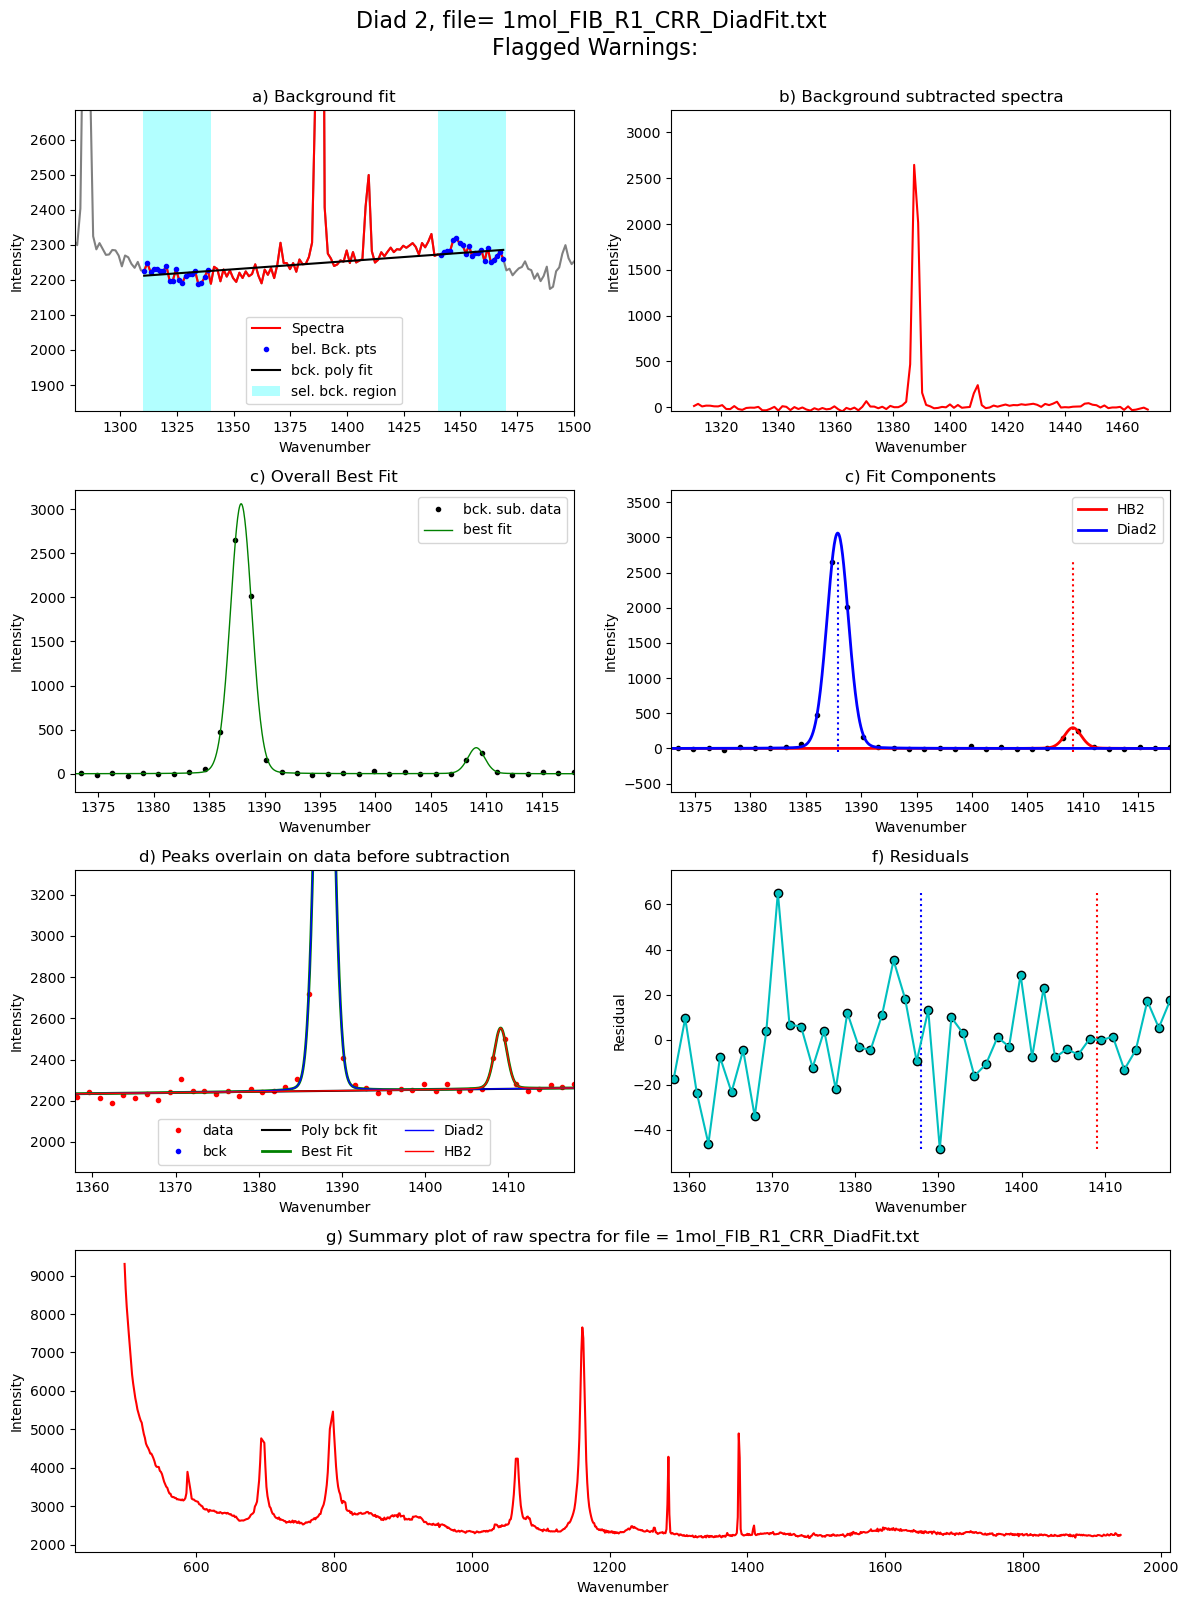

In [61]:
from tqdm import tqdm
plot_figure=True# If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    tqdm.write(f"Processing file: {Diad_Files[i]}")
    
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=GroupN_df['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=GroupN_df['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*GroupN_df['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=GroupN_df['filename'].iloc[i],
    filetype=filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad1_pos'].iloc[i],
    HB_pos=GroupN_df['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config_init.HB_prom=GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.diad_prom=GroupN_df['Diad2_abs_prom'].iloc[i]
    diad2_fit_config_init.gauss_amp= 2*GroupN_df['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.C13_prom=GroupN_df['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
        config2=diad_id_config,
    path=spectra_path, filename=GroupN_df['filename'].iloc[i], 
    filetype=filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=GroupN_df['Diad2_pos'].iloc[i],
    HB_pos=GroupN_df['HB2_pos'].iloc[i], 
    C13_pos=GroupN_df['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=GroupN_df['filename'].iloc[i], prefix=prefix, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0).reset_index(drop=True)


In [62]:
# Save parameters to excel
combo=df_Merge

if batch=='Weak':
    combo.to_excel('Weak_Diads.xlsx', index=False)
if batch=='Medium':
    combo.to_excel('Medium_Diads.xlsx', index=False)
if batch=='Strong':
    combo.to_excel('Strong_Diads.xlsx', index=False)

In [63]:
combo

filename   Splitting   Split_σ  Diad1_Combofit_Cent  \
0       10mol_FID_R1_CRR_DiadFit  102.837764  0.049599          1285.527123   
1   10mol_FID_R1_FIN_CRR_DiadFit  102.881692  0.017785          1285.522277   
2       10mol_FID_R2_CRR_DiadFit  102.864238  0.016689          1285.621099   
3   10mol_FID_R2_FIN_CRR_DiadFit  102.906732  0.014665          1285.569165   
4       10mol_FID_R3_CRR_DiadFit  102.958673  0.033886          1285.529762   
5   10mol_FID_R3_FIN_CRR_DiadFit  102.898406  0.024415          1285.535441   
6       10mol_FIE_R1_CRR_DiadFit  102.869488  0.064060          1285.462552   
7   10mol_FIE_R1_FIN_CRR_DiadFit  102.915297  0.015577          1285.738751   
8       10mol_FIE_R2_CRR_DiadFit  102.950230  0.027740          1285.833822   
9   10mol_FIE_R2_FIN_CRR_DiadFit  102.871080  0.020295          1285.619791   
10      10mol_FIE_R3_CRR_DiadFit  102.805556  0.119954          1285.966630   
11  10mol_FIE_R3_FIN_CRR_DiadFit  102.873336  0.021022          1285.697403   
12       1mol_FIB_R1_CRR_DiadFit  102.745280  0.038752          1285.142542   

    Diad1_cent_err  Diad1_Combofit_Height  Diad1_Voigt_Cent  Diad1_Voigt_Area  \
0         0.011785            5619.914244       1285.527273      16313.787114   
1         0.008970            5489.143325       1285.522327      15308.305416   
2         0.011235            4828.888698       1285.621149      13405.092078   
3         0.010588            5129.330337       1285.569215      14790.862119   
4         0.028336            2622.783494       1285.529812       7104.212376   
5         0.018544            3468.317115       1285.535491       9691.442456   
6         0.011481            4580.616882       1285.462602      12785.139856   
7         0.010099            4859.132897       1285.738801      13530.012024   
8         0.022503            1906.640135       1285.833972       5733.972110   
9         0.009668            5494.013165       1285.619841      15270.176161   
10        0.108815             990.938953       1285.966780       2847.311006   
11        0.012387            3790.954889       1285.697553      11050.602999   
12        0.037576            2049.803926       1285.142592       5369.496507   

    Diad1_Voigt_Sigma  Diad1_Residual  ...  HB2_Sigma  C13_Cent C13_Area  \
0            1.108289       34.965595  ...   1.205366       NaN      NaN   
1            1.094293       26.177196  ...   1.182390       NaN      NaN   
2            1.057224       27.092946  ...   1.159514       NaN      NaN   
3            1.118503       31.277471  ...   1.236657       NaN      NaN   
4            1.086294       34.073884  ...   1.363663       NaN      NaN   
5            1.089636       31.146390  ...   1.183144       NaN      NaN   
6            1.065018       24.485434  ...   1.352458       NaN      NaN   
7            1.110128       27.341346  ...   1.201348       NaN      NaN   
8            1.165296       23.332984  ...   1.429587       NaN      NaN   
9            1.090724       26.670417  ...   1.185924       NaN      NaN   
10           1.070947       59.079136  ...   1.609046       NaN      NaN   
11           1.145043       27.440511  ...   1.282871       NaN      NaN   
12           1.050132       37.145899  ...   0.908101       NaN      NaN   

    C13_Sigma  Diad2_Gauss_Cent  Diad2_Gauss_Area  Diad2_Gauss_Sigma  \
0         NaN               NaN               NaN                NaN   
1         NaN               NaN               NaN                NaN   
2         NaN               NaN               NaN                NaN   
3         NaN               NaN               NaN                NaN   
4         NaN               NaN               NaN                NaN   
5         NaN               NaN               NaN                NaN   
6         NaN               NaN               NaN                NaN   
7         NaN               NaN               NaN                NaN   
8         NaN               NaN               NaN                NaN 

### This plays a sound when the notebook is done if you have a tendency to procrastinate

In [64]:
# !pip install winotify

from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step3b_Secondary_Peaks is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()